### Size issue 
That file size of 28.45 GB for a single-cell RNA-seq .h5ad dataset is very large and will likely pose significant computational challenges for a standard analysis,
especially when using a Transformer-based model like GenFormer.

Memory (RAM): A 28 GB .h5ad file, which typically contains a sparse matrix of UMI counts, will require a substantial amount of RAM when loaded and processed. When the data is converted to a dense matrix or intermediate processing steps are performed (like calculating nearest neighbors, running PCA, etc.), the memory footprint can easily exceed 100-200 GB. If you don't have access to a high-memory computing environment (e.g., a powerful server or cloud instance), the analysis will crash.

Processing Time: Even with sufficient RAM, a dataset of this size (likely involving millions of cells) will result in long processing times for any single-cell workflow, particularly for computationally intensive steps like training a large neural network model such as GenFormer.

In [1]:
import os
import scanpy as sc
import anndata as ad
import pandas as pd
import cellxgene_census
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

In [4]:
metadata = pd.read_csv('/projects/bioinformatics/DB/scRNAseq_parkinson/metadata.csv')

In [7]:
metadata.columns

Index(['barcodekey', 'n_genes', 'n_counts', 'Brain_bank', 'RIN',
       'path_braak_lb', 'derived_class2', 'PMI', 'tissue_ontology_term_id',
       'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id',
       'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'sex_ontology_term_id',
       'donor_id', 'suspension_type', 'is_primary_data', 'cell_type', 'assay',
       'disease', 'sex', 'tissue', 'self_reported_ethnicity',
       'development_stage', 'observation_joinid'],
      dtype='object')

In [12]:
# ================================================
# Jupyter Notebook: Professional Review of scRNA-seq Metadata
# ================================================

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
%matplotlib inline

# -------------------------------
# 1. Load Metadata
# -------------------------------
metadata_path = '/projects/bioinformatics/DB/scRNAseq_parkinson/metadata.csv'
metadata = pd.read_csv(metadata_path)

# Quick overview
print("Metadata dimensions:", metadata.shape)
metadata.head()

Metadata dimensions: (2096155, 27)


barcodekey  n_genes  n_counts Brain_bank  RIN  \
0  Set10_C1-AAACCCACATCACGGC     2929    5645.0         UM  4.8   
1  Set10_C1-AAACCCAGTAGCACAG     4395   14741.0         UD  4.4   
2  Set10_C1-AAACCCAGTATGTCCA     3856   11005.0         UM  4.8   
3  Set10_C1-AAACCCAGTCCAGAAG     3387    8134.0         UD  4.4   
4  Set10_C1-AAACCCATCCACGTAA     2366    4583.0         UD  4.4   

   path_braak_lb derived_class2    PMI tissue_ontology_term_id tissue_type  \
0              3          Oligo  20.91          UBERON:0002477      tissue   
1              3          Oligo  20.91          UBERON:0001384      tissue   
2              3          Oligo  20.91          UBERON:0002477      tissue   
3              3          Oligo  20.91          UBERON:0001384      tissue   
4              3          Astro  20.91          UBERON:0001384      tissue   

   ... suspension_type is_primary_data        cell_type      assay  \
0  ...         nucleus            True  oligodendrocyte  10x 3' v3   
1  ...         nucleus            True  oligodendrocyte  10x 3' v3   
2  ...         nucleus            True  oligodendrocyte  10x 3' v3   
3  ...         nucleus            True  oligodendrocyte  10x 3' v3   
4  ...         nucleus            True        astrocyte  10x 3' v3   

             disease     sex                  tissue self_reported_ethnicity  \
0  Parkinson disease    male  medial globus pallidus                European   
1  Parkinson disease  female    primary motor cortex                European   
2  Parkinson disease    male  medial globus pallidus                European   
3  Parkinson disease  female    primary motor cortex                European   
4  Parkinson disease  female    primary motor cortex                European   

   development_stage observation_joinid  
0  82-year-old stage         MpT)aB)#*U  
1  73-year-old stage         qFT~wG^BCg  
2  82-year-old stage         fE`VpY%8fb  
3  73-year-old stage         g1Lr8^y)O(  
4  73-year-old stage         MR9tUCifao  

[5 rows x 27 columns]

In [13]:
# Professional MIT color palette
MIT_COLORS = ["#A31F34", "#8A8B8C", "#0A4E9B", "#D2D3D4", "#2A637B"]

sns.set(
    style="whitegrid",
    rc={
        "axes.edgecolor": "#333333",
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.figsize": (8,6),
        "axes.titleweight": "bold"
    }
)

# --------------------------------------------
# 2. Load Metadata
# --------------------------------------------
metadata = pd.read_csv('/projects/bioinformatics/DB/scRNAseq_parkinson/metadata.csv')

metadata.head()


barcodekey  n_genes  n_counts Brain_bank  RIN  \
0  Set10_C1-AAACCCACATCACGGC     2929    5645.0         UM  4.8   
1  Set10_C1-AAACCCAGTAGCACAG     4395   14741.0         UD  4.4   
2  Set10_C1-AAACCCAGTATGTCCA     3856   11005.0         UM  4.8   
3  Set10_C1-AAACCCAGTCCAGAAG     3387    8134.0         UD  4.4   
4  Set10_C1-AAACCCATCCACGTAA     2366    4583.0         UD  4.4   

   path_braak_lb derived_class2    PMI tissue_ontology_term_id tissue_type  \
0              3          Oligo  20.91          UBERON:0002477      tissue   
1              3          Oligo  20.91          UBERON:0001384      tissue   
2              3          Oligo  20.91          UBERON:0002477      tissue   
3              3          Oligo  20.91          UBERON:0001384      tissue   
4              3          Astro  20.91          UBERON:0001384      tissue   

   ... suspension_type is_primary_data        cell_type      assay  \
0  ...         nucleus            True  oligodendrocyte  10x 3' v3   
1  ...         nucleus            True  oligodendrocyte  10x 3' v3   
2  ...         nucleus            True  oligodendrocyte  10x 3' v3   
3  ...         nucleus            True  oligodendrocyte  10x 3' v3   
4  ...         nucleus            True        astrocyte  10x 3' v3   

             disease     sex                  tissue self_reported_ethnicity  \
0  Parkinson disease    male  medial globus pallidus                European   
1  Parkinson disease  female    primary motor cortex                European   
2  Parkinson disease    male  medial globus pallidus                European   
3  Parkinson disease  female    primary motor cortex                European   
4  Parkinson disease  female    primary motor cortex                European   

   development_stage observation_joinid  
0  82-year-old stage         MpT)aB)#*U  
1  73-year-old stage         qFT~wG^BCg  
2  82-year-old stage         fE`VpY%8fb  
3  73-year-old stage         g1Lr8^y)O(  
4  73-year-old stage         MR9tUCifao  

[5 rows x 27 columns]

In [14]:
unique_donors = metadata["donor_id"].nunique()
print("Number of unique donors:", unique_donors)


Number of unique donors: 97


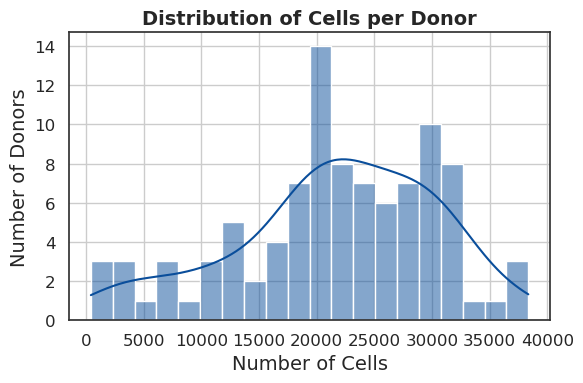

In [30]:
plt.figure(figsize=(6,4))
sns.histplot(cells_per_donor.values, bins=20, color=MIT_COLORS[2], kde=True)
plt.title("Distribution of Cells per Donor", fontsize=14, weight="bold")
plt.xlabel("Number of Cells")
plt.ylabel("Number of Donors")
plt.tight_layout()
plt.show()


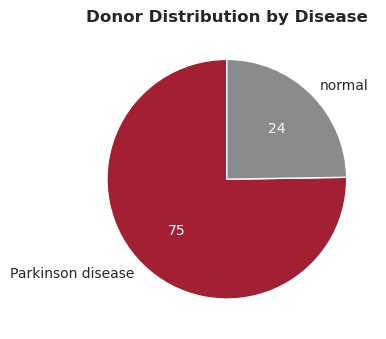

In [38]:
plt.figure(figsize=(4,4))

# Colors (MIT palette)
colors = MIT_COLORS[:len(disease_counts)]

# Create pie chart
patches, texts, autotexts = plt.pie(
    disease_counts.values,
    labels=disease_counts.index,
    autopct='%d',          # show raw numbers
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)

# Bold title
plt.title("Donor Distribution by Disease", fontsize=12, weight='bold')

# Improve number visibility (move numbers slightly outward)
for t in autotexts:
    t.set_fontsize(10)
    t.set_color("white")

plt.tight_layout()
plt.show()


In [19]:
sex_counts = metadata.groupby("donor_id")["sex"].first().value_counts()
sex_counts


sex
male      60
female    37
Name: count, dtype: int64

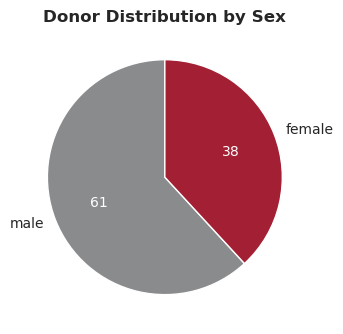

In [40]:
plt.figure(figsize=(4,3.5))

# Colors (MIT palette)
colors = list(reversed(MIT_COLORS[:len(sex_counts)]))

# Create pie chart
patches, texts, autotexts = plt.pie(
    sex_counts.values,
    labels=sex_counts.index,
    autopct='%d',          # show raw counts
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)

# Bold title
plt.title("Donor Distribution by Sex", fontsize=12, weight='bold')

# Adjust number visibility
for t in autotexts:
    t.set_fontsize(10)
    t.set_color("white")

plt.tight_layout()
plt.show()


In [41]:
# Take first non-missing disease per donor
disease_counts = metadata.groupby("donor_id")["disease"].first()

# Drop any donors without disease info
disease_counts = disease_counts.dropna()

# Count donors per disease
disease_counts = disease_counts.value_counts()

# Check total donors
print("Total donors counted:", disease_counts.sum())  # should match unique_donors if no missing


Total donors counted: 97


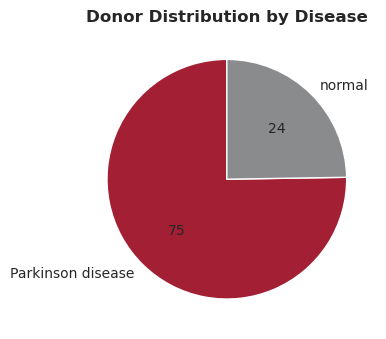

In [42]:
plt.figure(figsize=(4,4))

# Colors (MIT palette)
colors = MIT_COLORS[:len(disease_counts)]

plt.pie(
    disease_counts.values,
    labels=disease_counts.index,
    autopct='%d',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)

plt.title("Donor Distribution by Disease", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


In [54]:
# Keep only unique donors with their disease
unique_donors = metadata[['donor_id', 'disease']].drop_duplicates(subset='donor_id')

# Optional: replace missing disease with 'Unknown'
unique_donors['disease'] = unique_donors['disease'].fillna('Unknown')

# Count donors per disease
disease_counts = unique_donors['disease'].value_counts()

print(disease_counts)

disease
Parkinson disease    73
normal               24
Name: count, dtype: int64


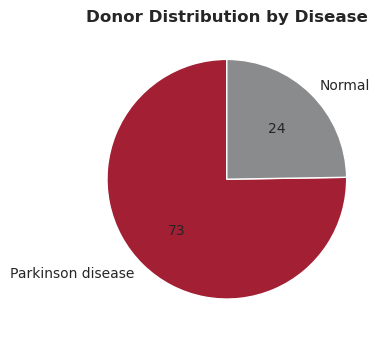

In [66]:
plt.figure(figsize=(4,4))
colors = MIT_COLORS[:len(disease_counts)]

# Function to display raw counts
def show_counts(pct, all_values):
    total = sum(all_values)
    count = int(round(pct*total/100))
    return str(count)

plt.pie(
    disease_counts.values,
    labels=disease_counts.index,
    autopct=lambda pct: show_counts(pct, disease_counts.values),  # raw counts
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)

plt.title("Donor Distribution by Disease", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------------
# 2. Basic Information
# -------------------------------
print("Columns in metadata:\n", metadata.columns.tolist())
print("\nData types:")
print(metadata.dtypes)
print("\nMissing values per column:")
print(metadata.isna().sum())

In [ ]:
# -------------------------------
# 3. Summary Statistics for Numeric Fields
# -------------------------------
numeric_cols = ['n_genes', 'n_counts', 'RIN', 'PMI', 'path_braak_lb']
metadata[numeric_cols].describe()

# Histogram and boxplots
for col in numeric_cols:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    sns.histplot(metadata[col], kde=True, ax=ax[0], color='skyblue')
    ax[0].set_title(f'Histogram of {col}')
    
    sns.boxplot(x=metadata[col], ax=ax[1], color='lightgreen')
    ax[1].set_title(f'Boxplot of {col}')
    
    plt.show()

In [ ]:
# -------------------------------
# 4. Categorical Data Review
# -------------------------------
categorical_cols = [
    'Brain_bank', 'derived_class2', 'tissue_ontology_term_id', 'tissue_type',
    'assay_ontology_term_id', 'disease_ontology_term_id', 
    'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
    'development_stage_ontology_term_id', 'sex_ontology_term_id',
    'suspension_type', 'is_primary_data', 'cell_type', 'assay',
    'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
]

for col in categorical_cols:
    counts = metadata[col].value_counts(dropna=False)
    print(f"\nColumn: {col}")
    print(counts)
    
    plt.figure(figsize=(10,4))
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Cell count')
    plt.show()


In [ ]:
# -------------------------------
# 5. Cross-tabulations and QC Insights
# -------------------------------

# Example: Cell types per brain bank
ct_bank = pd.crosstab(metadata['cell_type'], metadata['Brain_bank'])
ct_bank_norm = ct_bank.div(ct_bank.sum(axis=0), axis=1)  # normalized
plt.figure(figsize=(12,6))
sns.heatmap(ct_bank_norm, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Proportion of Cell Types per Brain Bank')
plt.ylabel('Cell Type')
plt.xlabel('Brain Bank')
plt.show()

# Example: n_genes vs n_counts scatter
plt.figure(figsize=(8,6))
sns.scatterplot(data=metadata, x='n_counts', y='n_genes', hue='cell_type', alpha=0.6, palette='tab10')
plt.title('n_genes vs n_counts per cell type')
plt.xlabel('n_counts')
plt.ylabel('n_genes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
# -------------------------------
# 6. Metadata Correlations
# -------------------------------
numeric_corr = metadata[numeric_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(numeric_corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix of Numeric Metadata")
plt.show()


In [ ]:
# -------------------------------
# 7. Optional: Missing Value Patterns
# -------------------------------
import missingno as msno
msno.matrix(metadata, figsize=(12,4))
plt.show()

msno.heatmap(metadata, figsize=(10,6))
plt.show()

Metadata dimensions: (2096155, 27)
Columns in metadata:
 ['barcodekey', 'n_genes', 'n_counts', 'Brain_bank', 'RIN', 'path_braak_lb', 'derived_class2', 'PMI', 'tissue_ontology_term_id', 'tissue_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'donor_id', 'suspension_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid']

Data types:
barcodekey                                   object
n_genes                                       int64
n_counts                                    float64
Brain_bank                                   object
RIN                                         float64
path_braak_lb                                 int64
derived_class2                               object
PMI                                         float64
tissue_onto

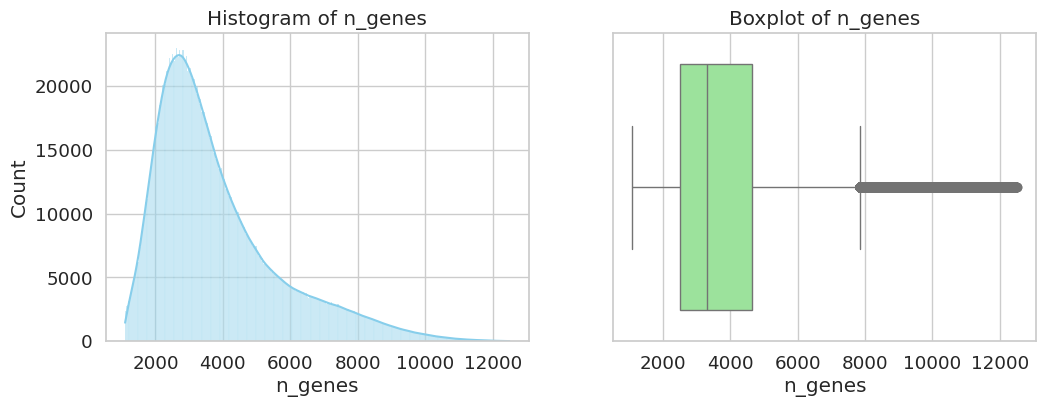

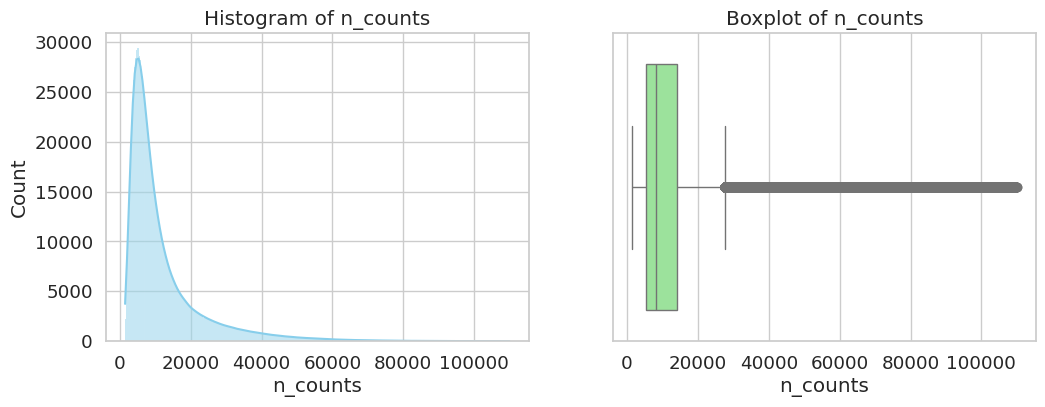

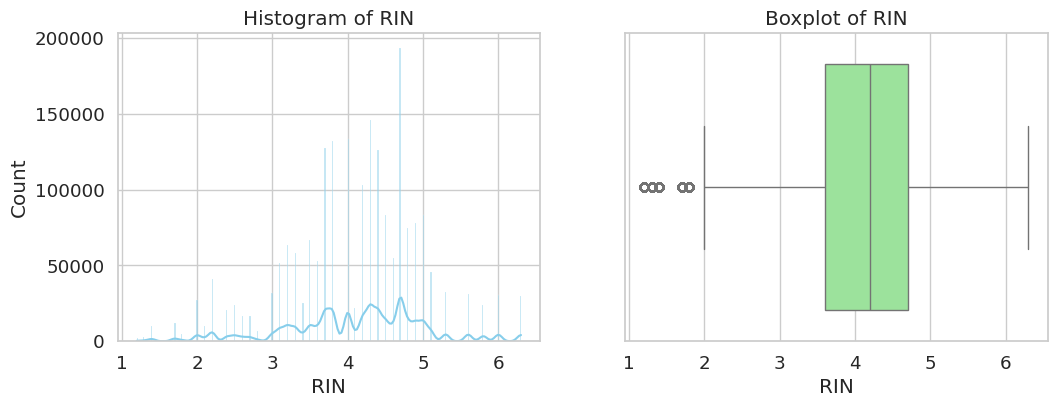

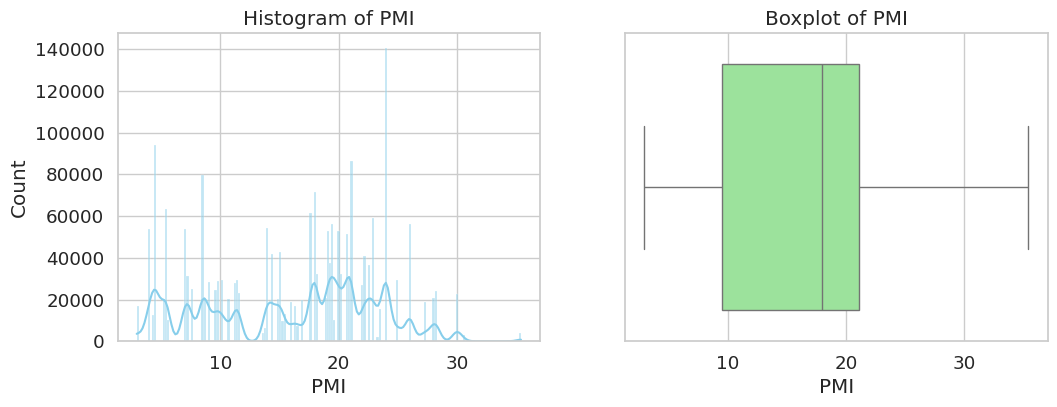

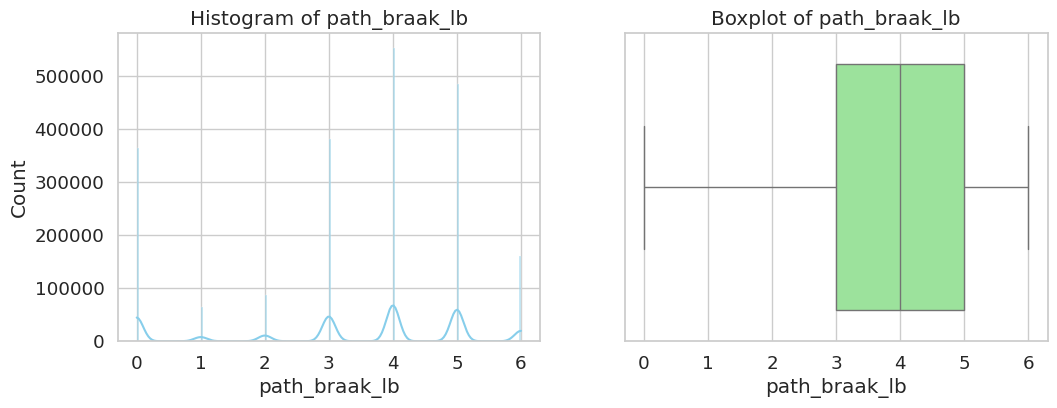


Column: Brain_bank
Brain_bank
UM         667865
UD         544202
Harvard    455888
MSSM       428200
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


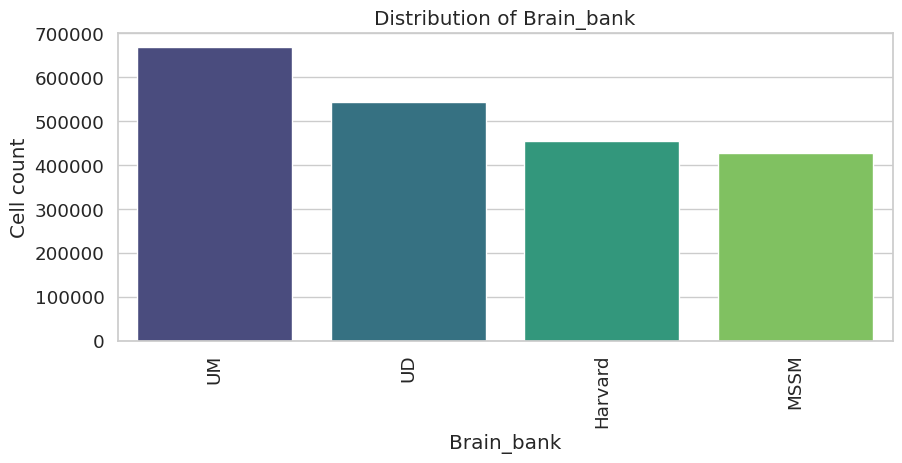


Column: derived_class2
derived_class2
Oligo        1093520
EN            328856
Astro         227452
IN            152393
Micro_PVM     118515
OPC           112585
Mural          17865
DMNX_Neu       14206
Ependymal      12559
Endo           11070
GPI_Neu         4773
Adaptive        2361
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


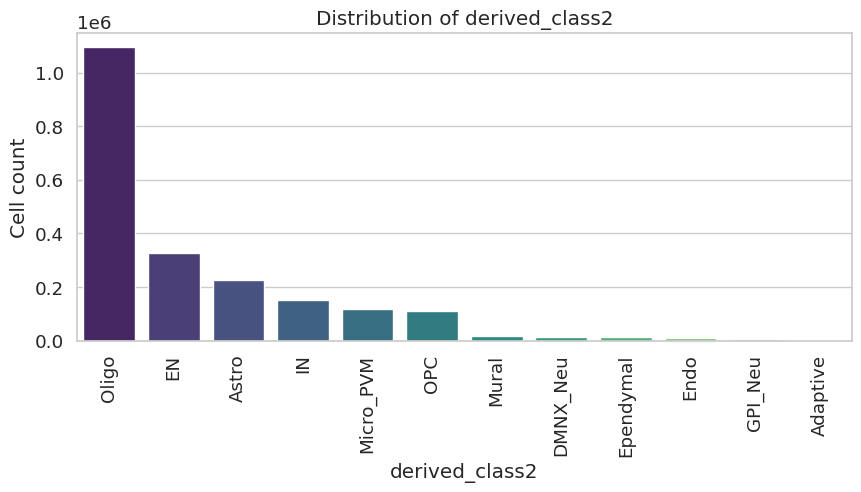


Column: tissue_ontology_term_id
tissue_ontology_term_id
UBERON:0000451    503414
UBERON:0001384    466475
UBERON:0002436    436737
UBERON:0002477    385587
UBERON:0002870    303942
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


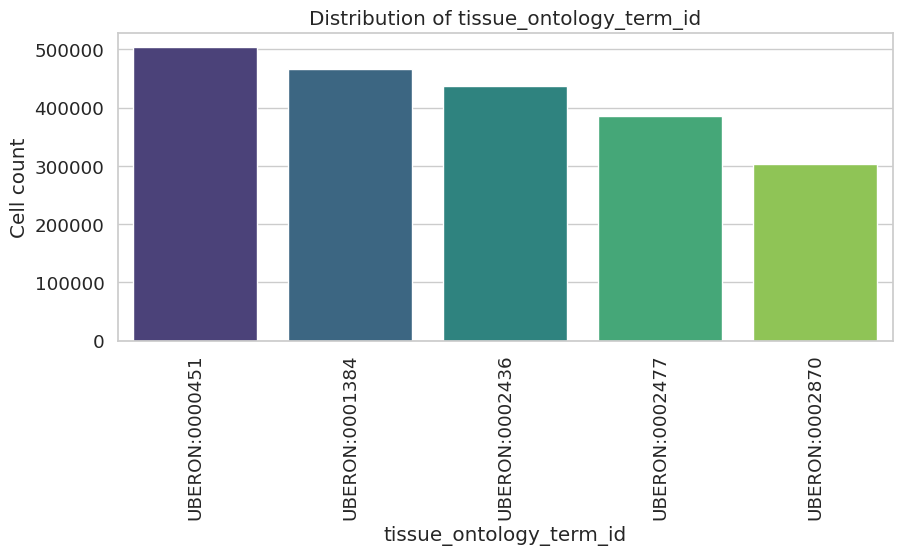


Column: tissue_type
tissue_type
tissue    2096155
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


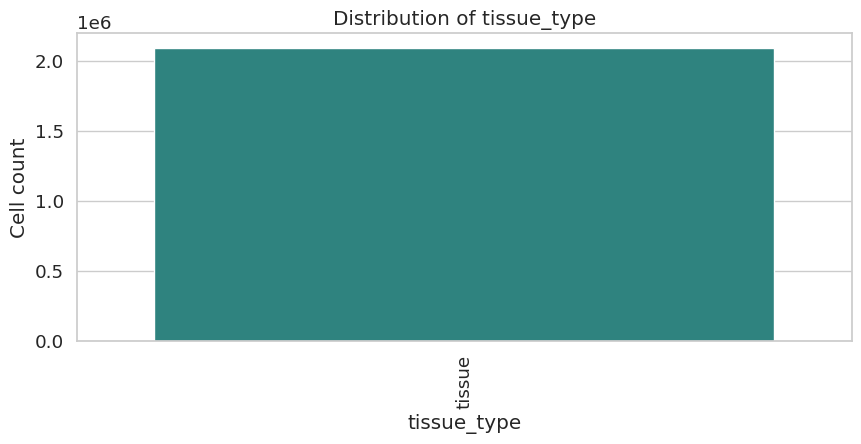


Column: assay_ontology_term_id
assay_ontology_term_id
EFO:0009922    2096155
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


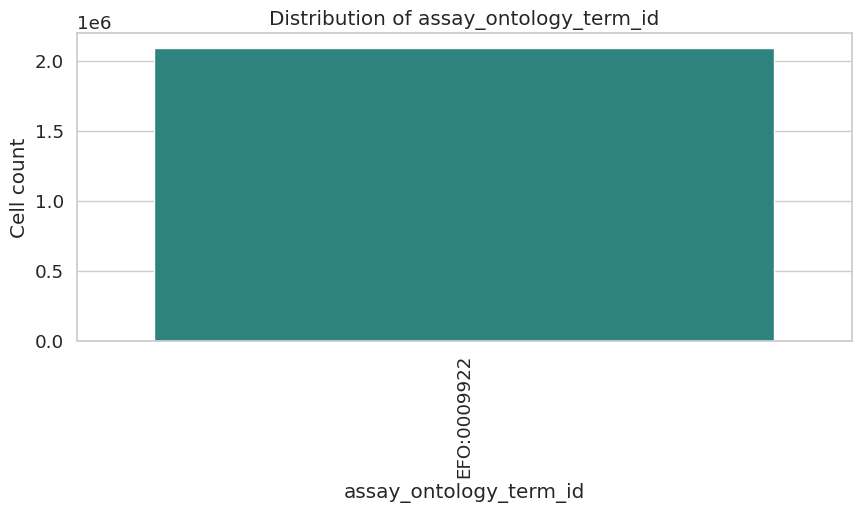


Column: disease_ontology_term_id
disease_ontology_term_id
MONDO:0005180    1650858
PATO:0000461      445297
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


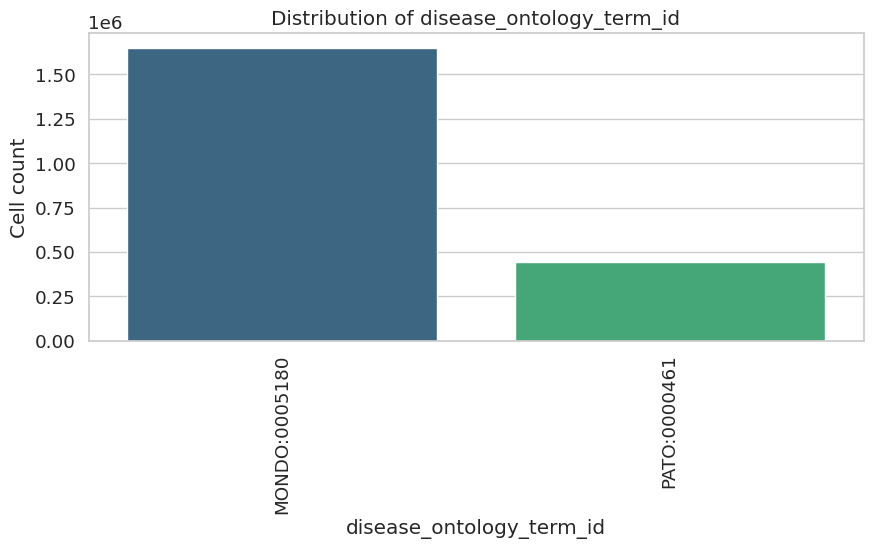


Column: cell_type_ontology_term_id
cell_type_ontology_term_id
CL:0000128    1093520
CL:0000679     328856
CL:0000127     227452
CL:0000617     152393
CL:0000878     118515
CL:0002453     112585
CL:2000029      18979
CL:0008034      17865
CL:0000065      12559
CL:0000115      11070
CL:0000738       2361
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


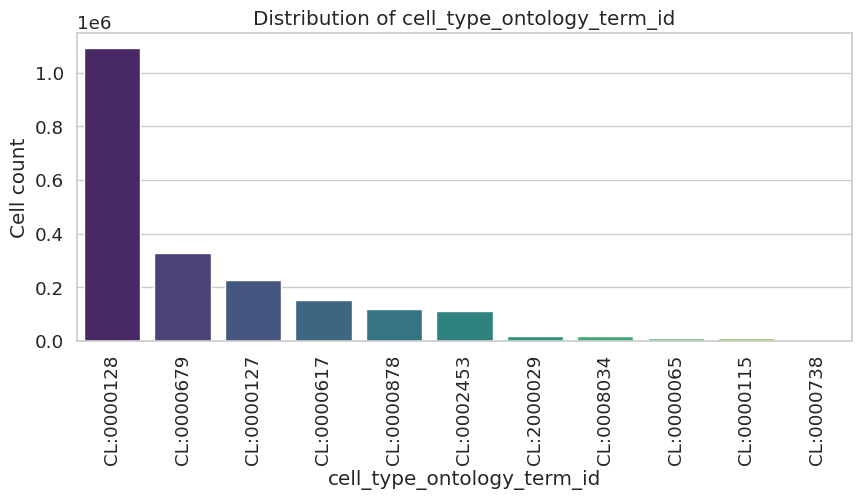


Column: self_reported_ethnicity_ontology_term_id
self_reported_ethnicity_ontology_term_id
HANCESTRO:0005    1999400
unknown             43706
HANCESTRO:0010      29537
HANCESTRO:0006      23512
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


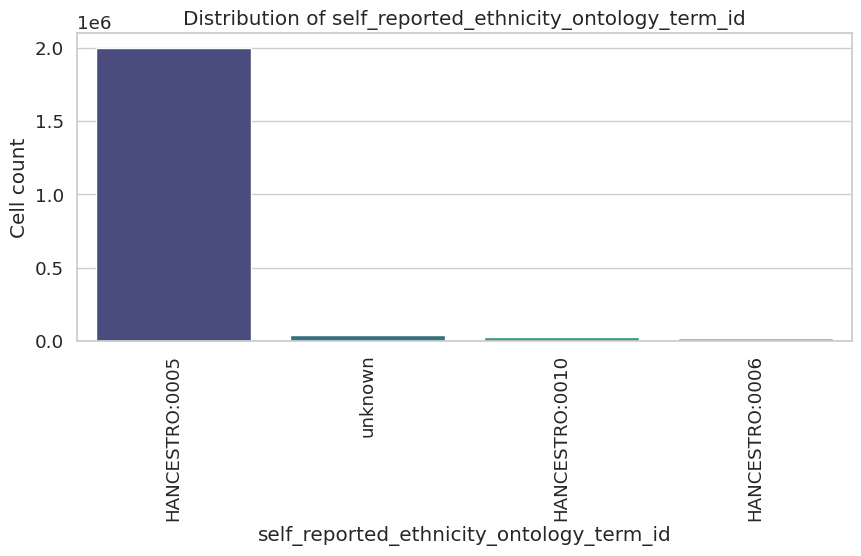


Column: development_stage_ontology_term_id
development_stage_ontology_term_id
HsapDv:0000207    177783
HsapDv:0000169    137308
HsapDv:0000208    124617
HsapDv:0000206    117281
HsapDv:0000173    112090
HsapDv:0000166    108944
HsapDv:0000171    102425
HsapDv:0000211    100359
HsapDv:0000161     90200
HsapDv:0000217     86804
HsapDv:0000172     82633
HsapDv:0000210     78785
HsapDv:0000170     77478
HsapDv:0000209     61289
HsapDv:0000212     57256
HsapDv:0000168     55608
HsapDv:0000214     50204
HsapDv:0000213     47013
HsapDv:0000160     37938
HsapDv:0000229     37638
HsapDv:0000164     37589
HsapDv:0000167     36868
HsapDv:0000215     35271
HsapDv:0000162     32978
HsapDv:0000221     32977
HsapDv:0000230     32066
HsapDv:0000163     25158
HsapDv:0000223     24161
HsapDv:0000156     22183
HsapDv:0000151     19142
HsapDv:0000158     18706
HsapDv:0000159     18424
HsapDv:0000165     16979
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


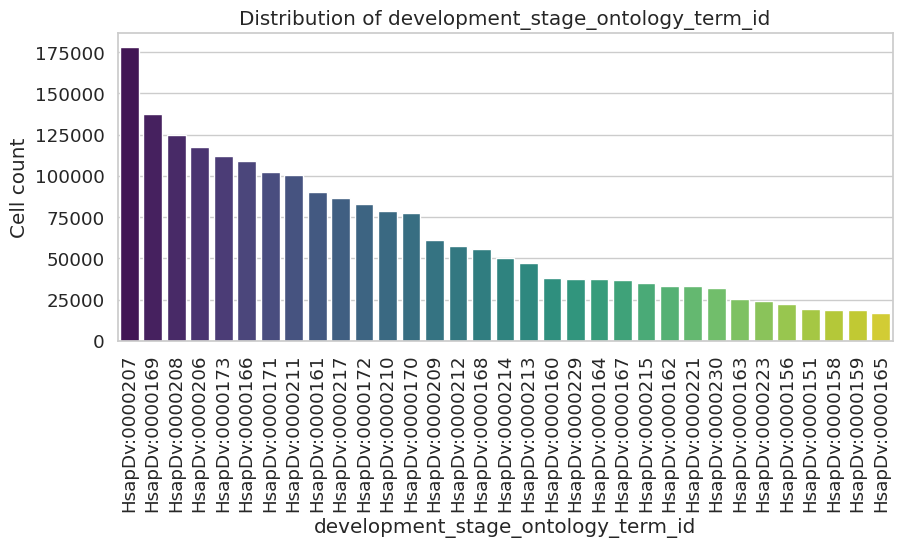


Column: sex_ontology_term_id
sex_ontology_term_id
PATO:0000384    1301834
PATO:0000383     794321
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


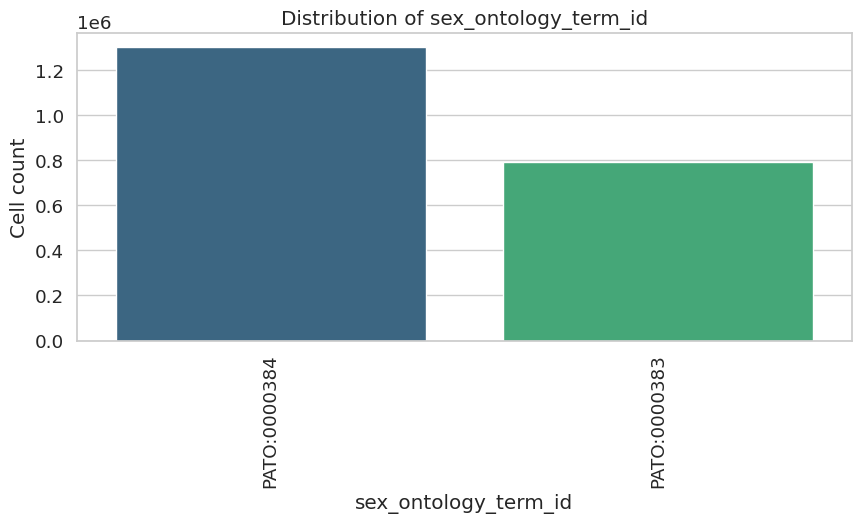


Column: suspension_type
suspension_type
nucleus    2096155
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


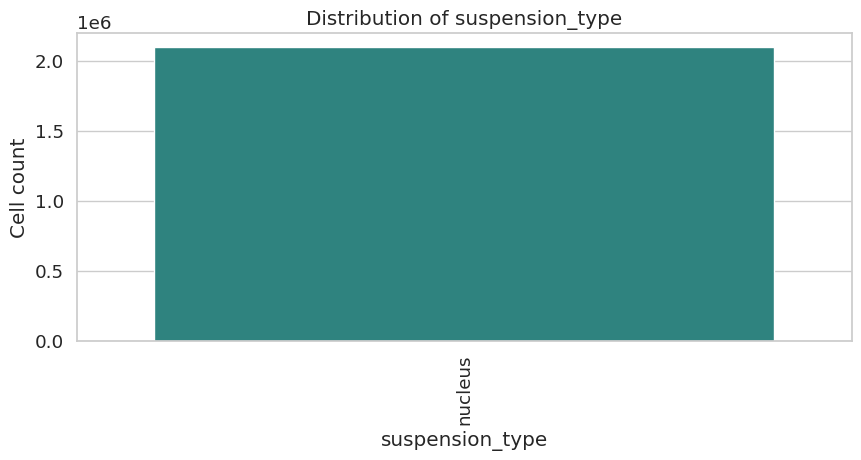


Column: is_primary_data
is_primary_data
True    2096155
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


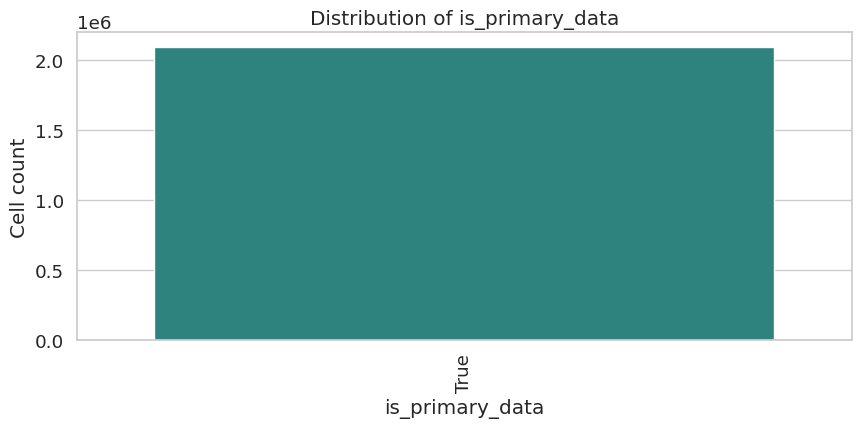


Column: cell_type
cell_type
oligodendrocyte                      1093520
glutamatergic neuron                  328856
astrocyte                             227452
GABAergic neuron                      152393
central nervous system macrophage     118515
oligodendrocyte precursor cell        112585
central nervous system neuron          18979
mural cell                             17865
ependymal cell                         12559
endothelial cell                       11070
leukocyte                               2361
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


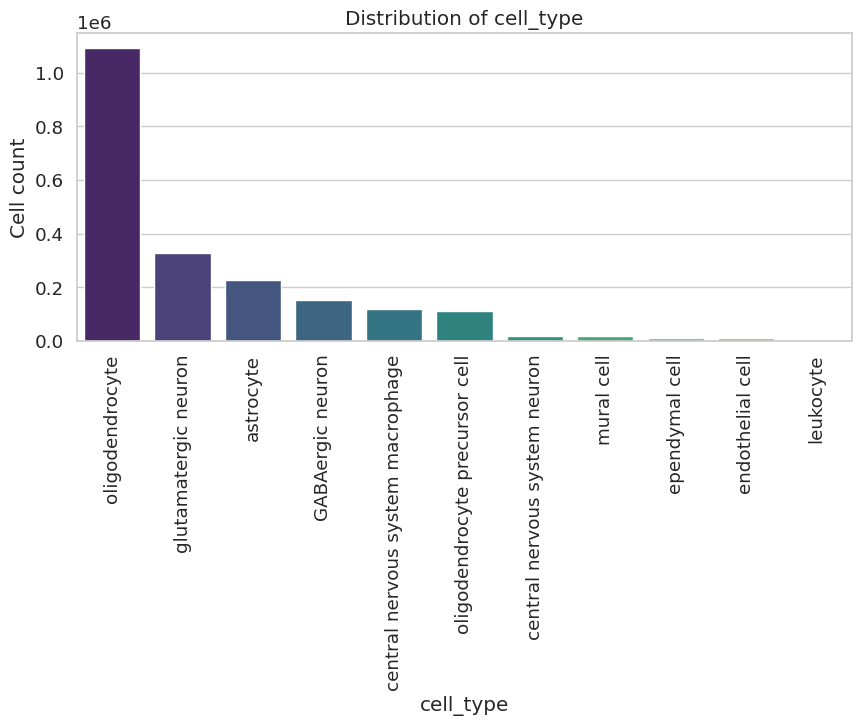


Column: assay
assay
10x 3' v3    2096155
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


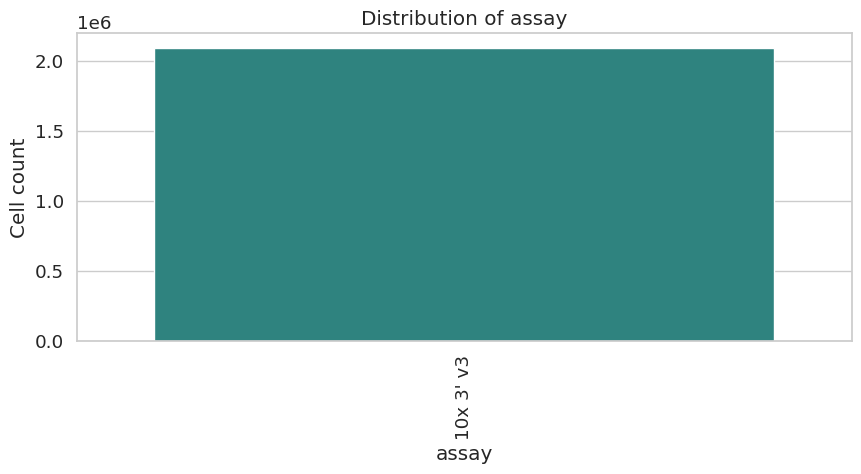


Column: disease
disease
Parkinson disease    1650858
normal                445297
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


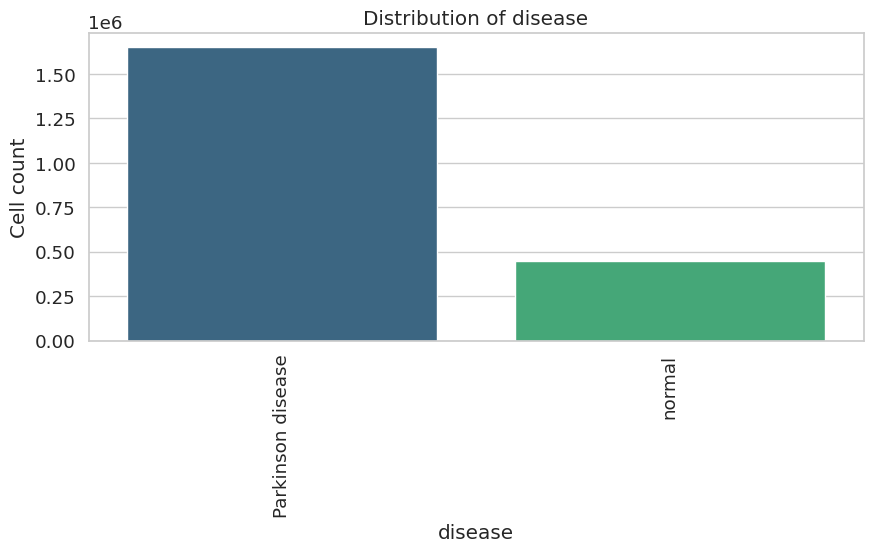


Column: sex
sex
male      1301834
female     794321
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


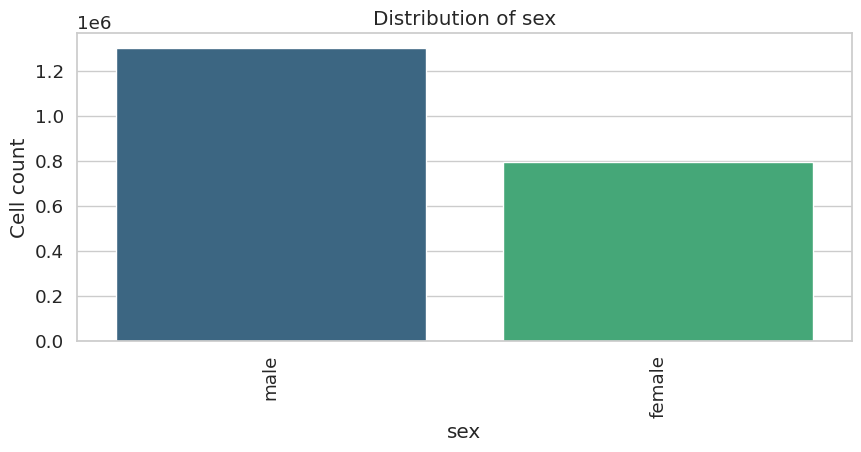


Column: tissue
tissue
prefrontal cortex                      503414
primary motor cortex                   466475
primary visual cortex                  436737
medial globus pallidus                 385587
dorsal motor nucleus of vagus nerve    303942
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


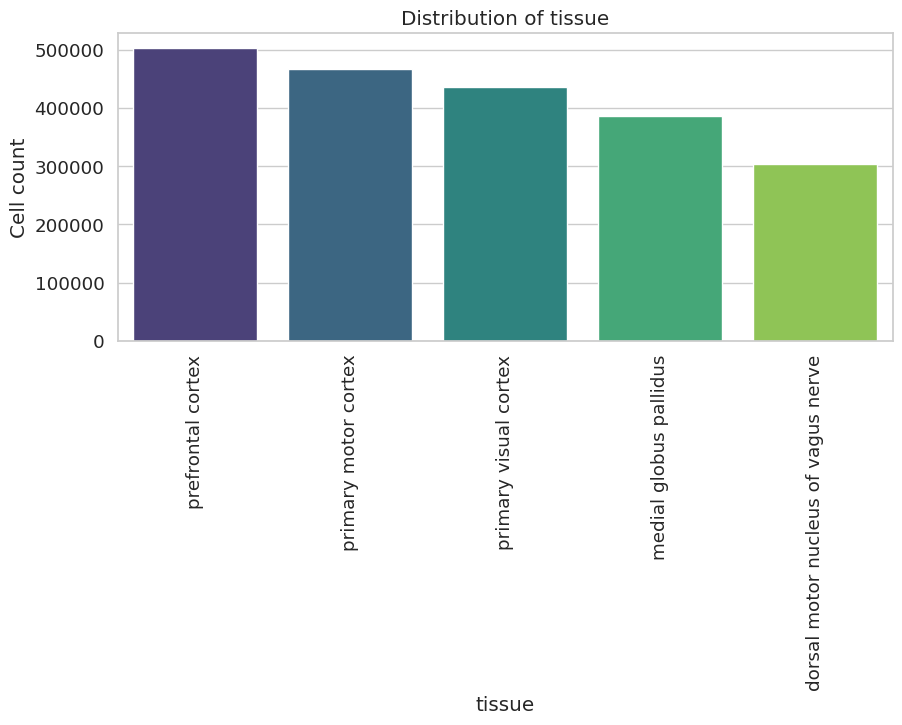


Column: self_reported_ethnicity
self_reported_ethnicity
European       1999400
unknown          43706
African          29537
South Asian      23512
Name: count, dtype: int64


/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


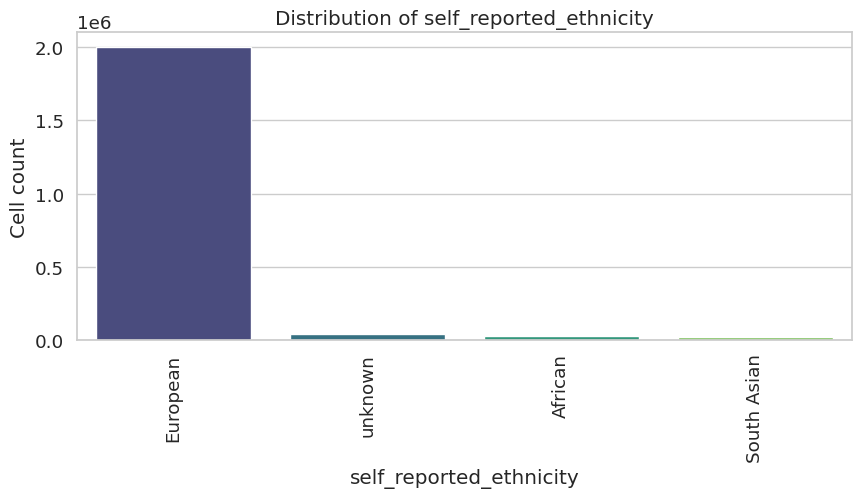


Column: development_stage
development_stage
81-year-old stage     177783
75-year-old stage     137308
82-year-old stage     124617
80-year-old stage     117281
79-year-old stage     112090
72-year-old stage     108944
77-year-old stage     102425
85-year-old stage     100359
67-year-old stage      90200
91-year-old stage      86804
78-year-old stage      82633
84-year-old stage      78785
76-year-old stage      77478
83-year-old stage      61289
86-year-old stage      57256
74-year-old stage      55608
88-year-old stage      50204
87-year-old stage      47013
66-year-old stage      37938
101-year-old stage     37638
70-year-old stage      37589
73-year-old stage      36868
89-year-old stage      35271
68-year-old stage      32978
95-year-old stage      32977
102-year-old stage     32066
69-year-old stage      25158
97-year-old stage      24161
62-year-old stage      22183
57-year-old stage      19142
64-year-old stage      18706
65-year-old stage      18424
71-year-old stage      1697

/var/tmp/pbs.402076.pbs01/ipykernel_24680/559509900.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


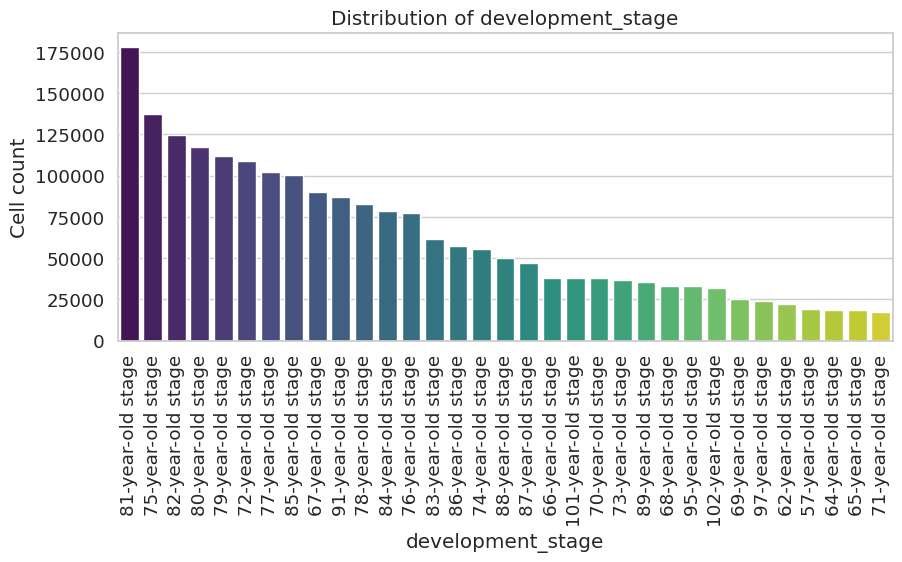

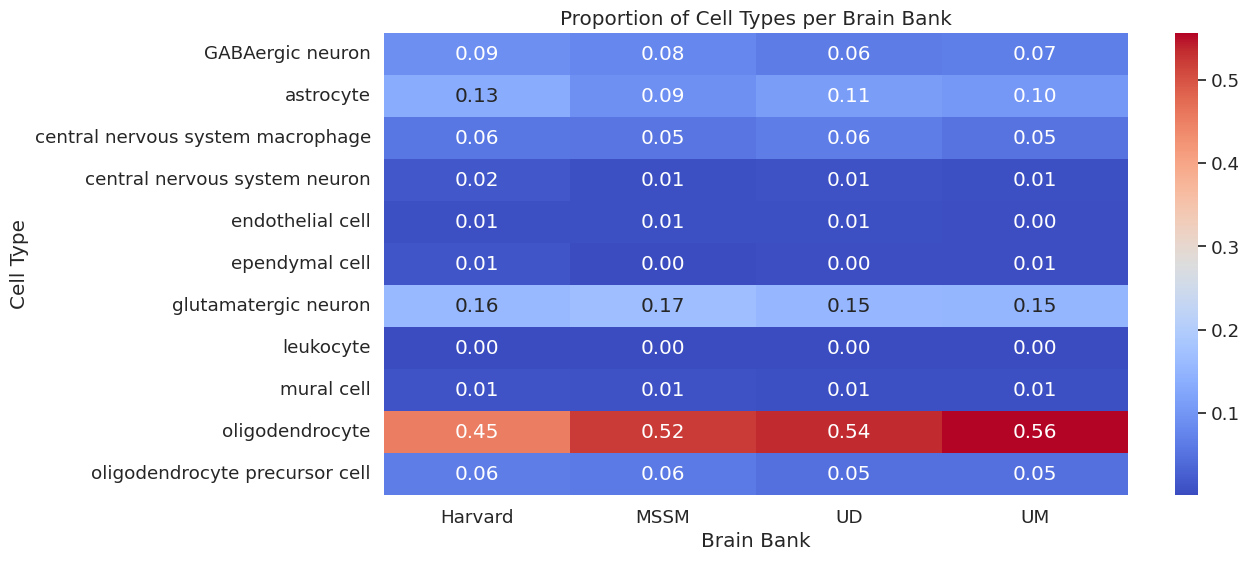

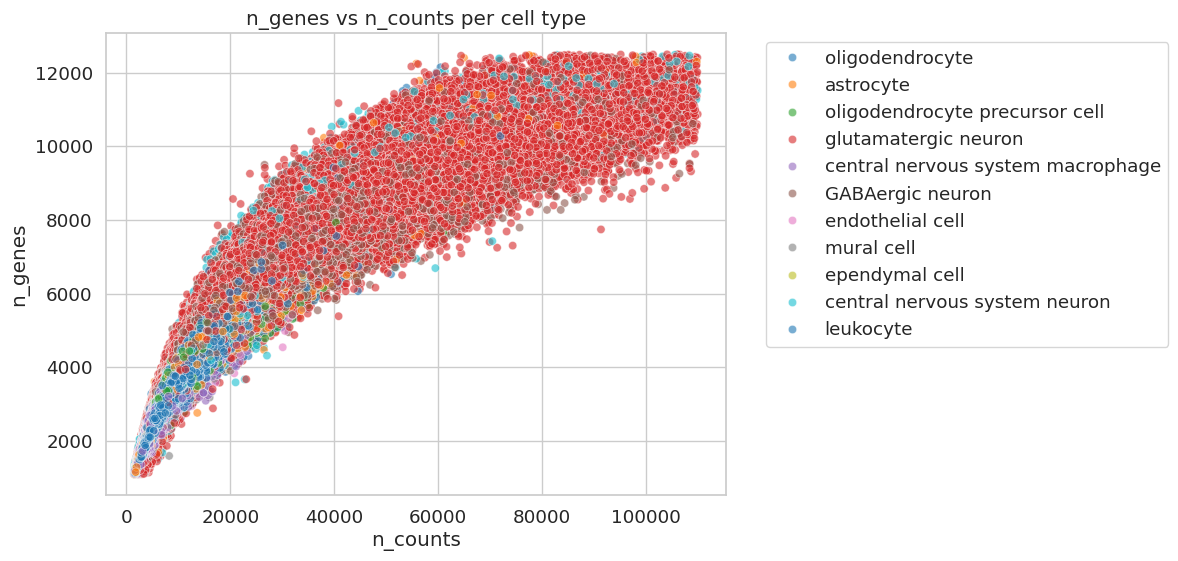

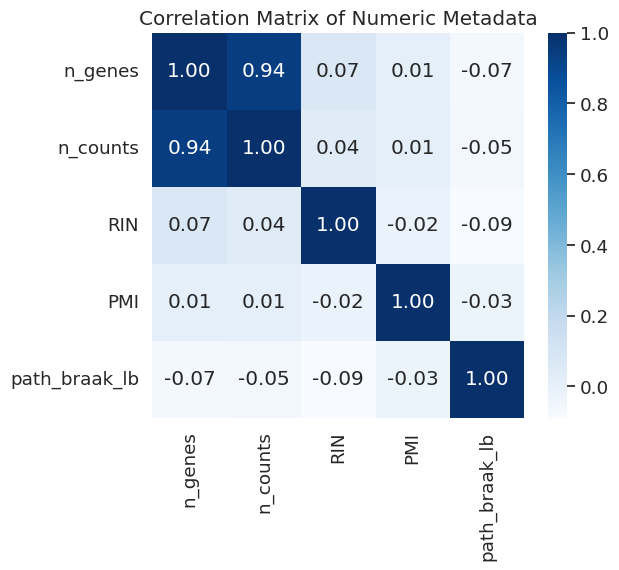

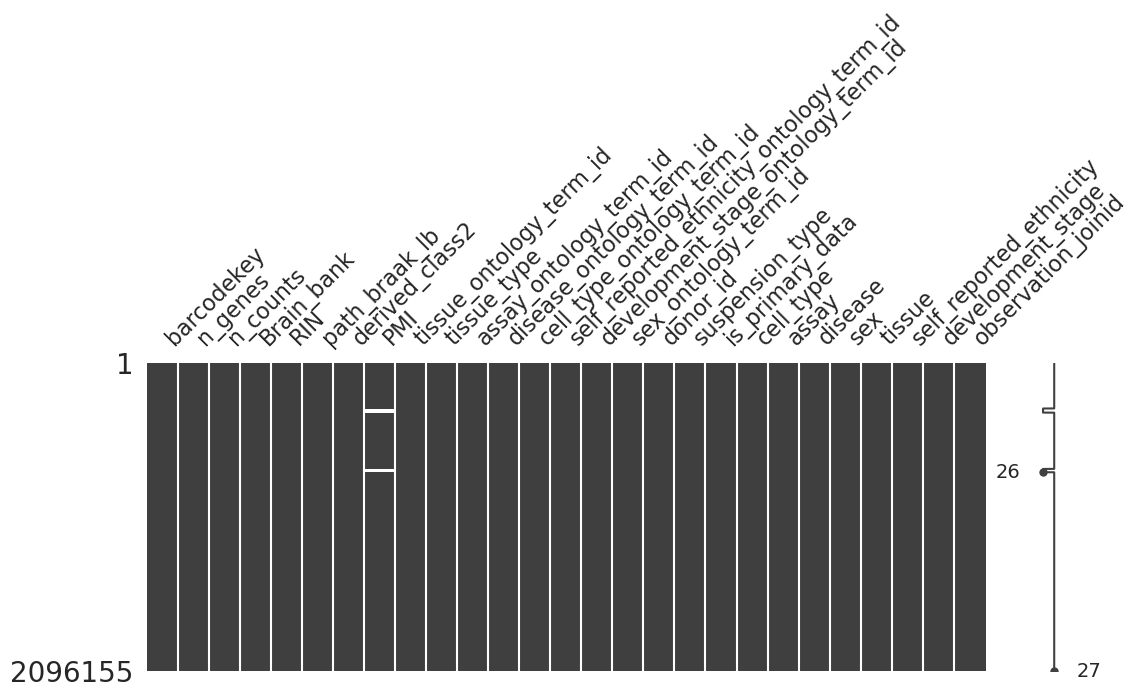

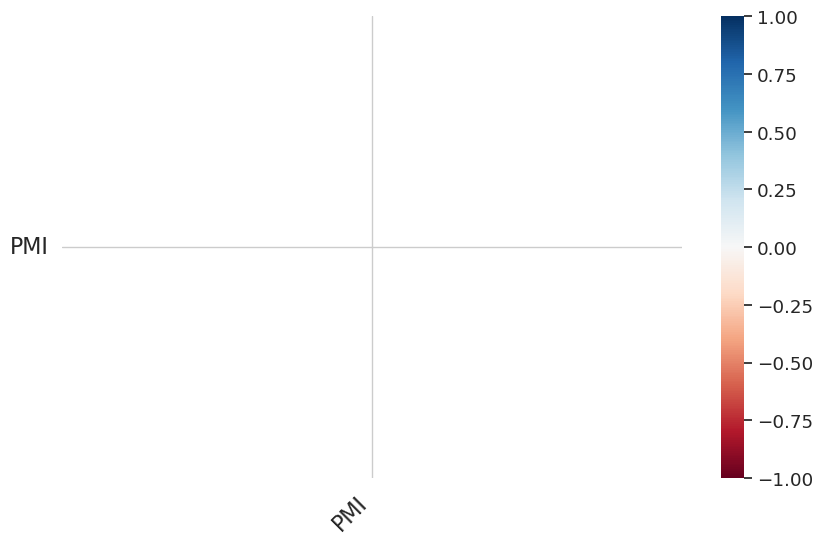

Metadata review completed successfully.


Metadata dimensions: (2096155, 27)
barcodekey                                   object
n_genes                                       int64
n_counts                                    float64
Brain_bank                                   object
RIN                                         float64
path_braak_lb                                 int64
derived_class2                               object
PMI                                         float64
tissue_ontology_term_id                      object
tissue_type                                  object
assay_ontology_term_id                       object
disease_ontology_term_id                     object
cell_type_ontology_term_id                   object
self_reported_ethnicity_ontology_term_id     object
development_stage_ontology_term_id           object
sex_ontology_term_id                         object
donor_id                                     object
suspension_type                              object
is_primary_data              

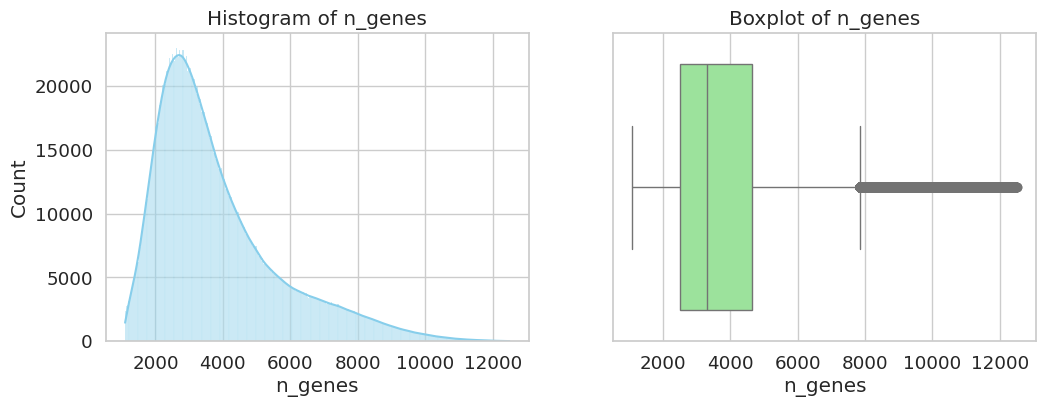

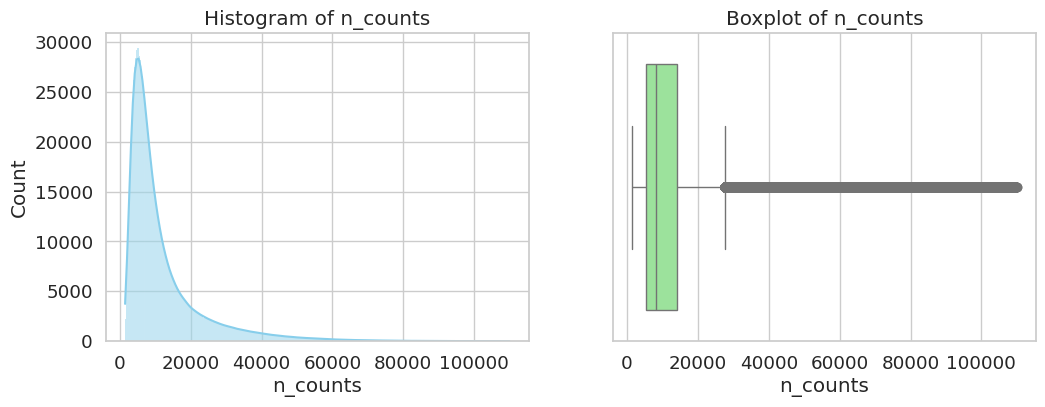

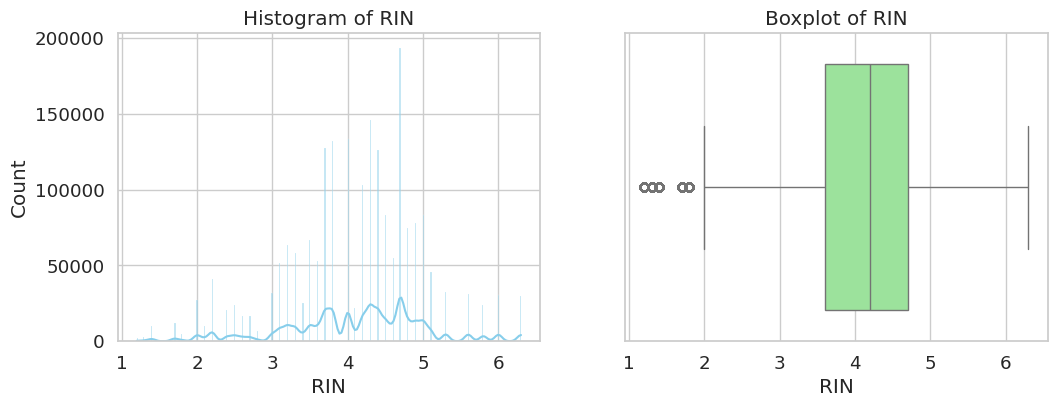

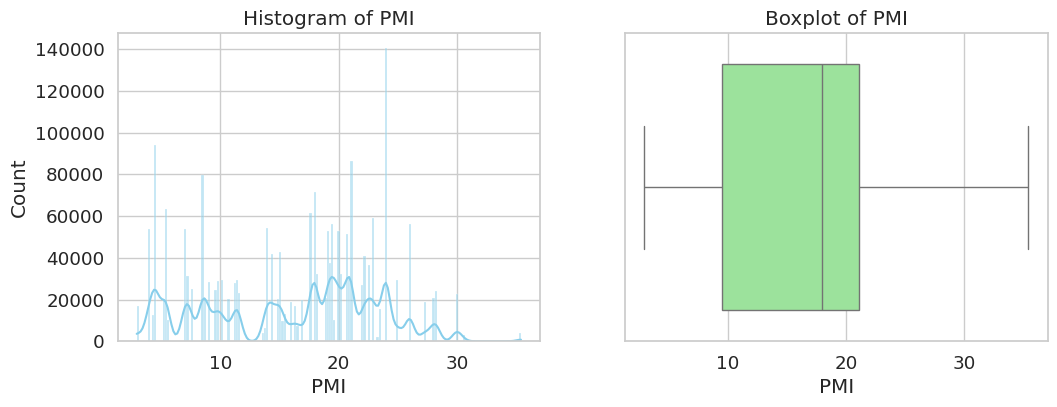

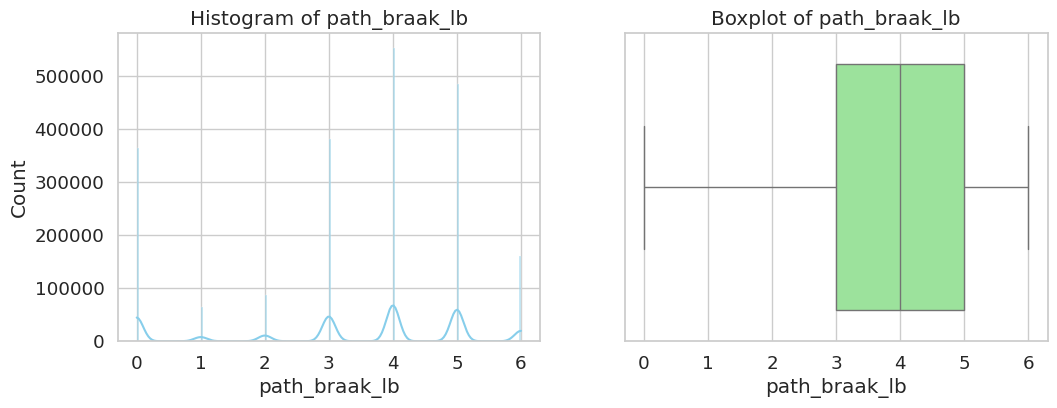

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


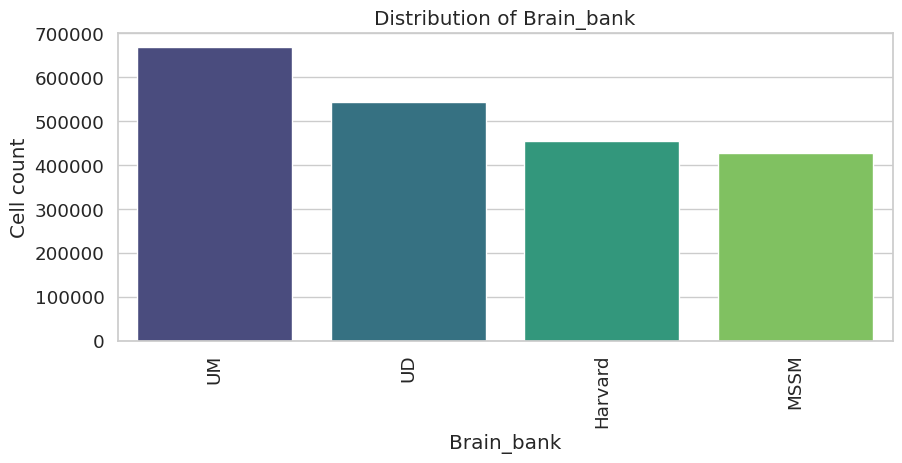

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


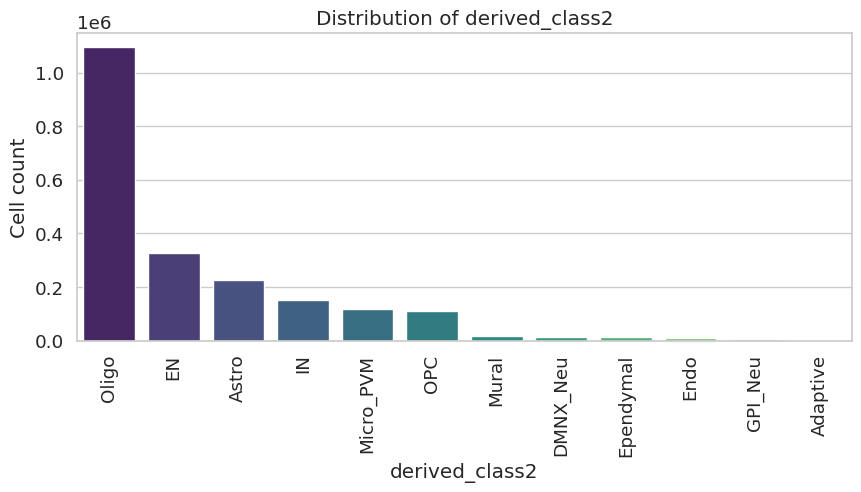

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


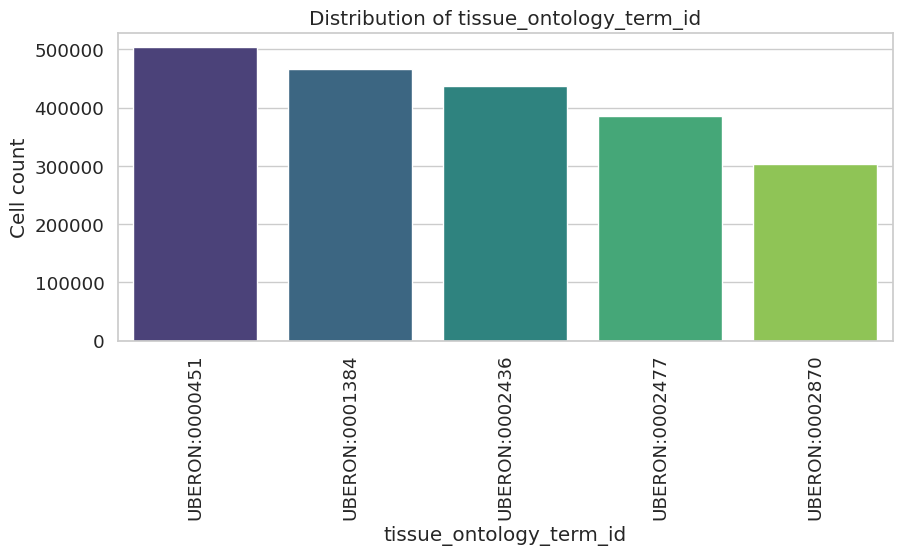

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


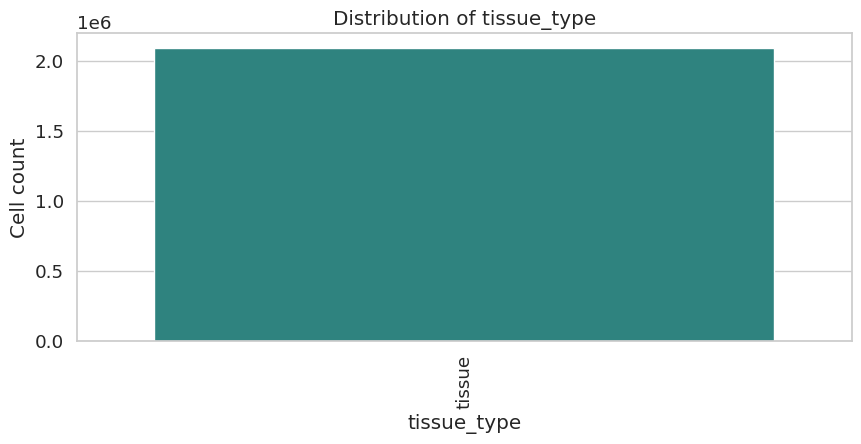

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


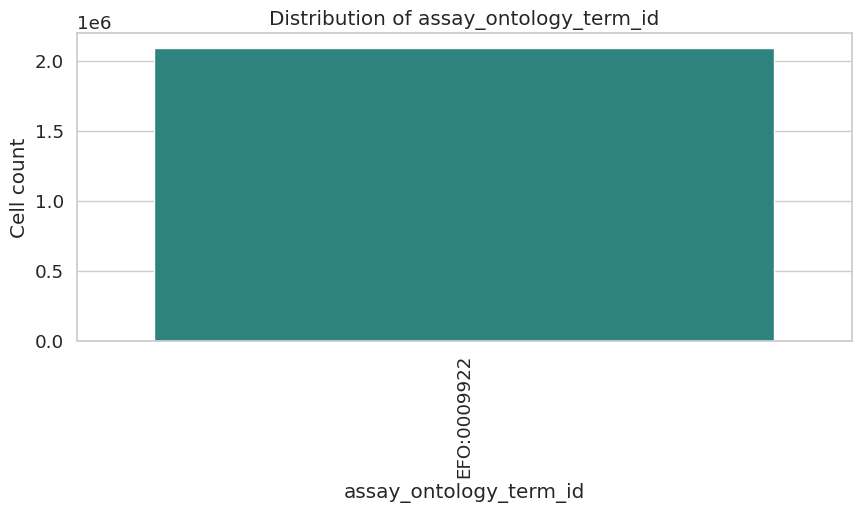

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


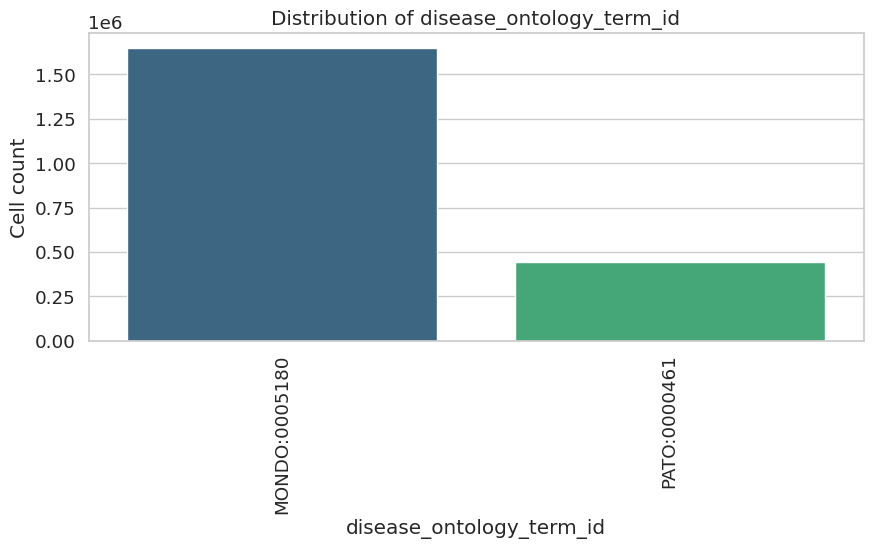

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


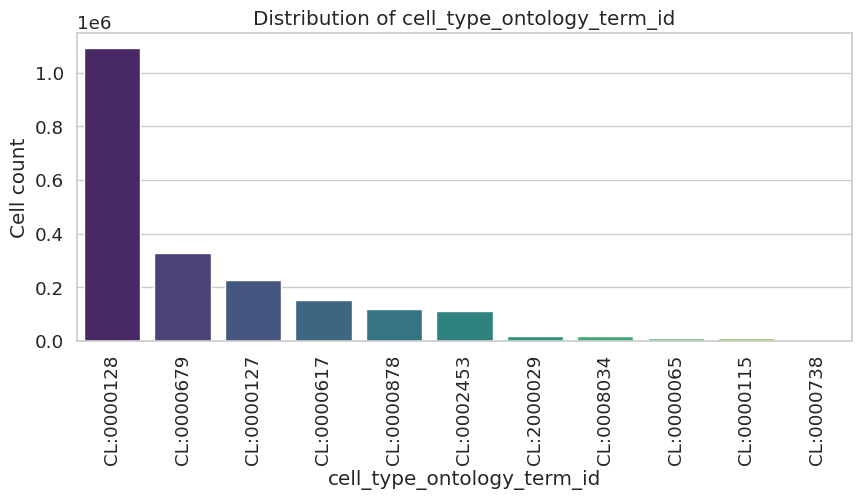

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


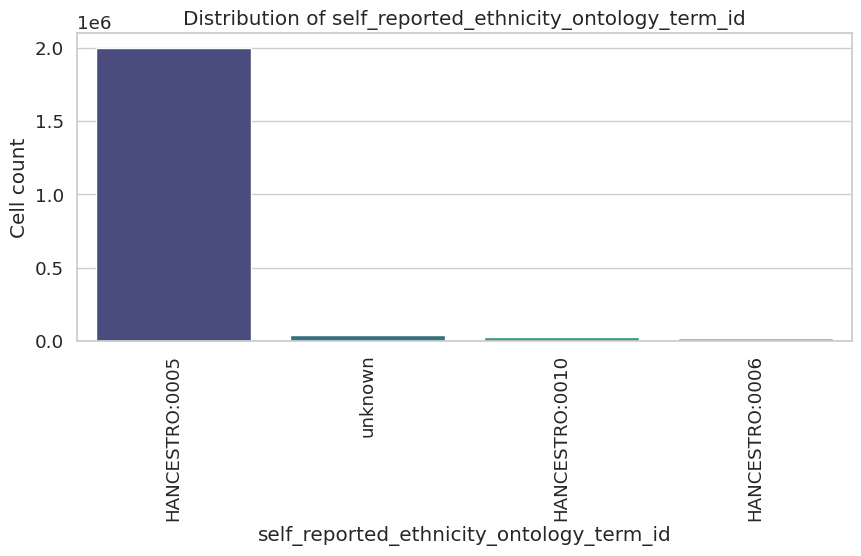

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


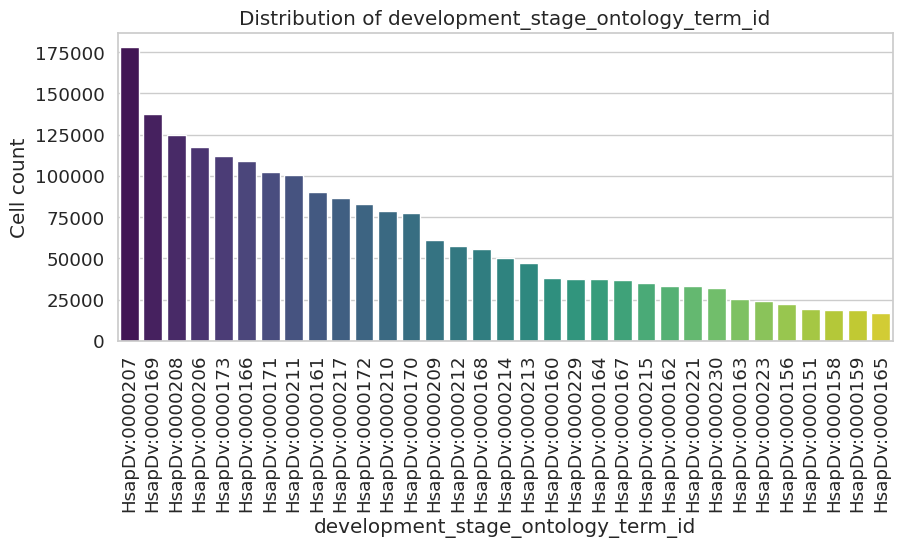

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


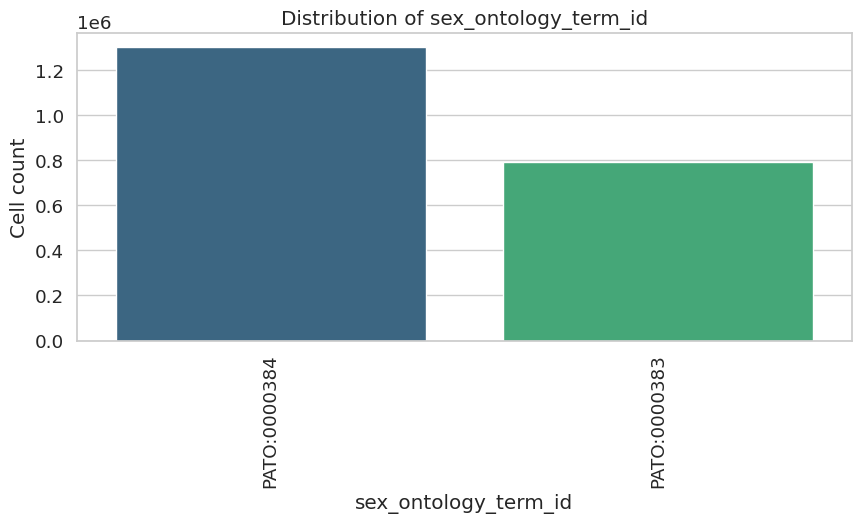

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


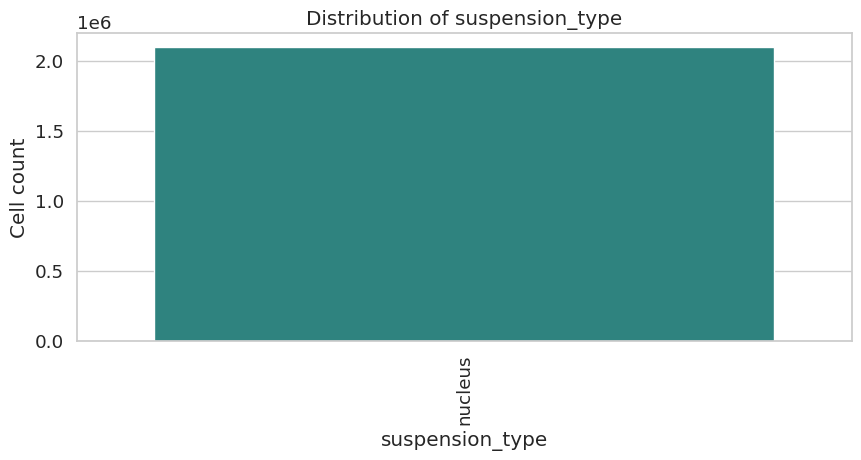

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


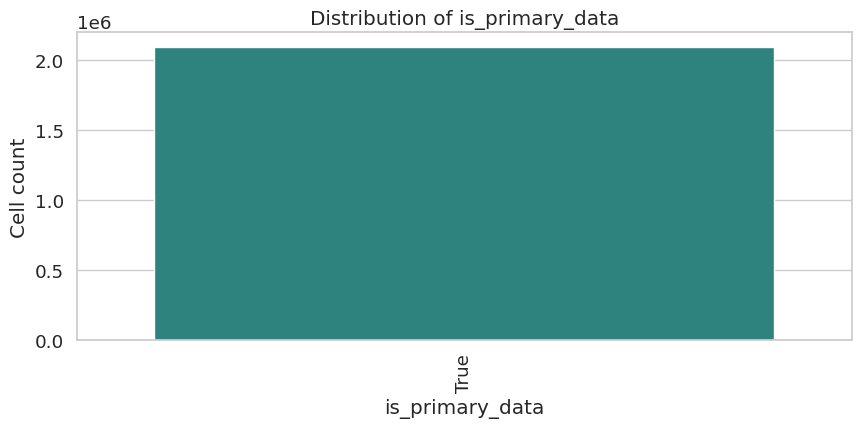

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


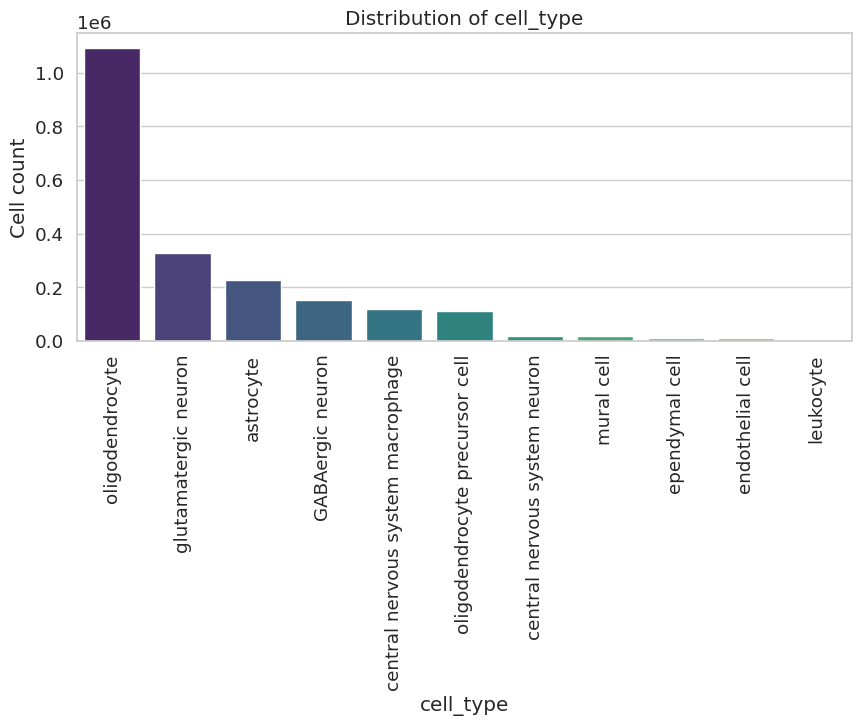

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


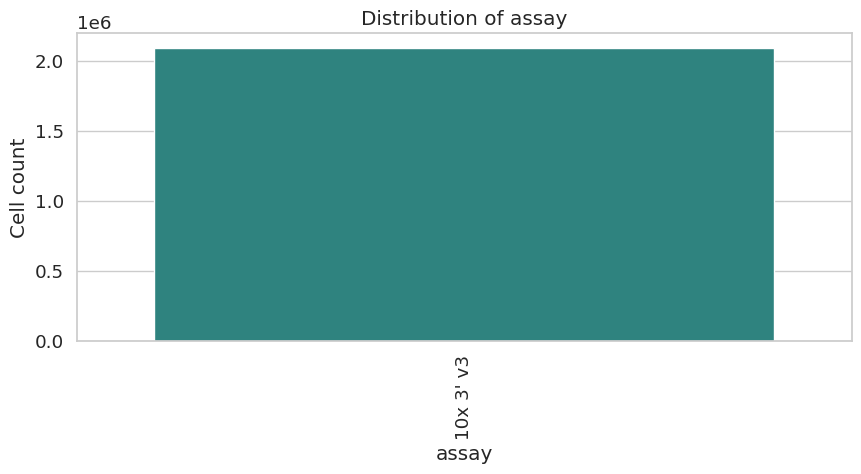

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


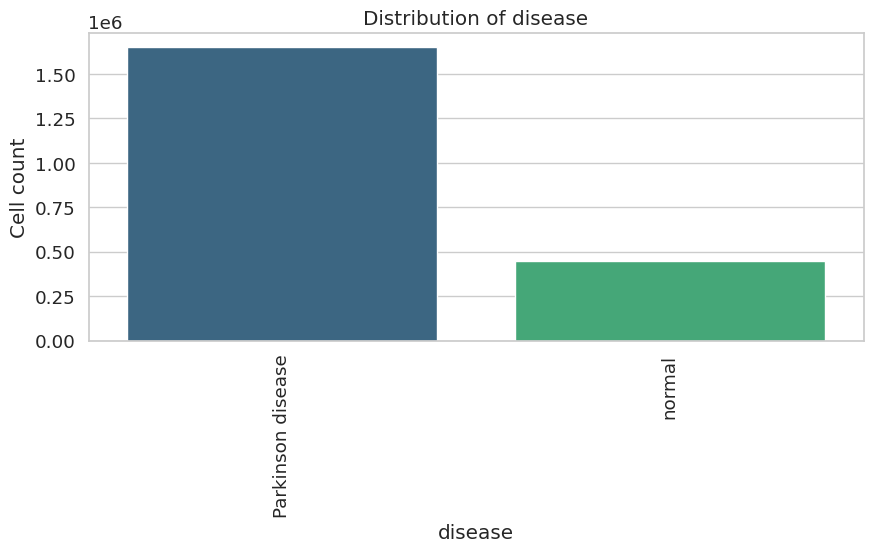

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


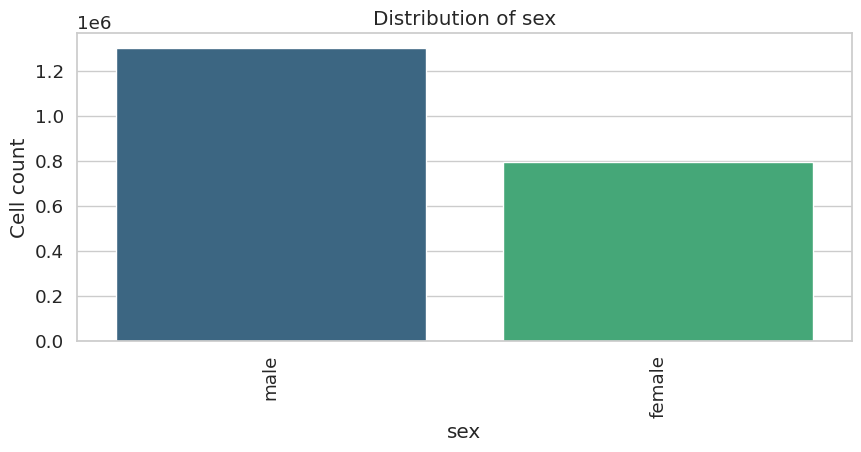

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


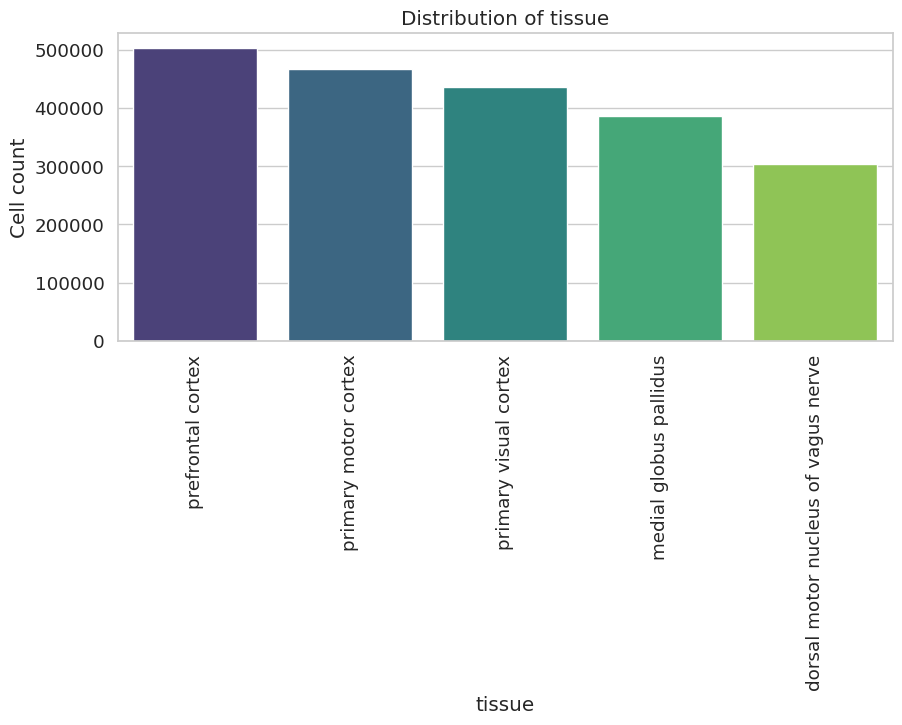

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


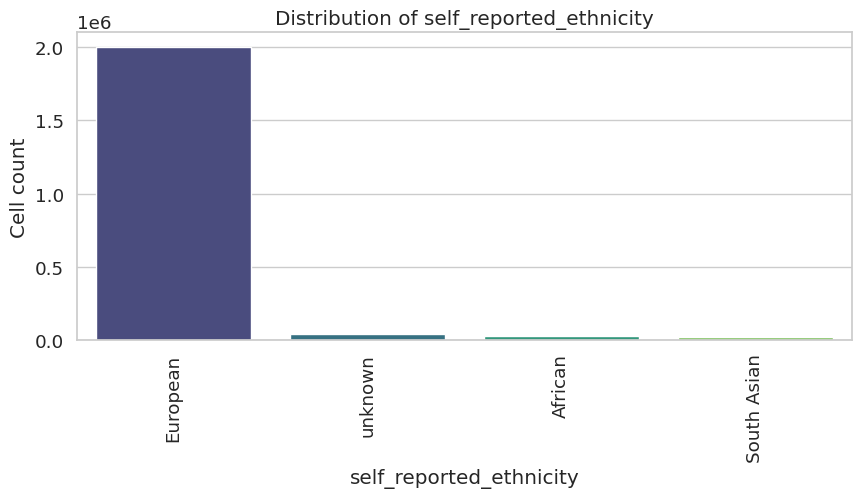

/var/tmp/pbs.402076.pbs01/ipykernel_24680/2442443563.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


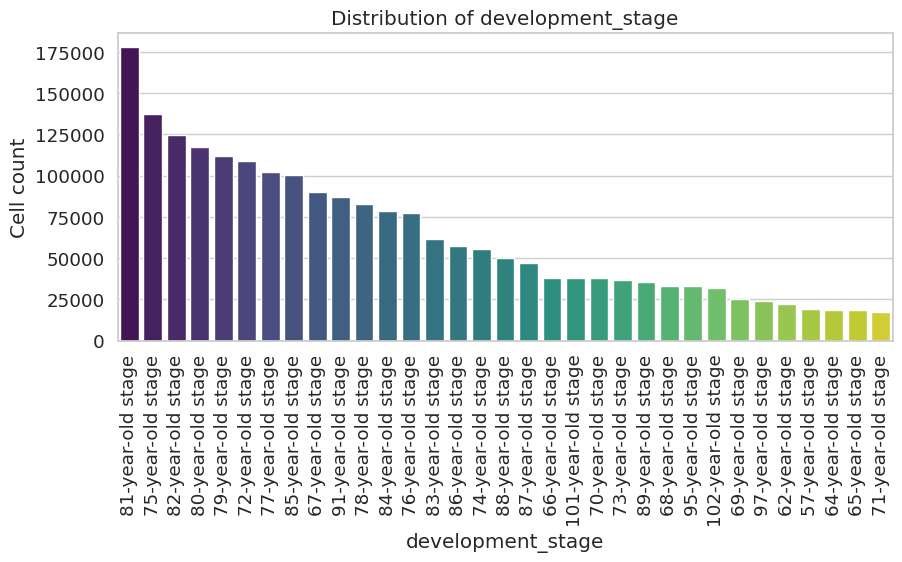

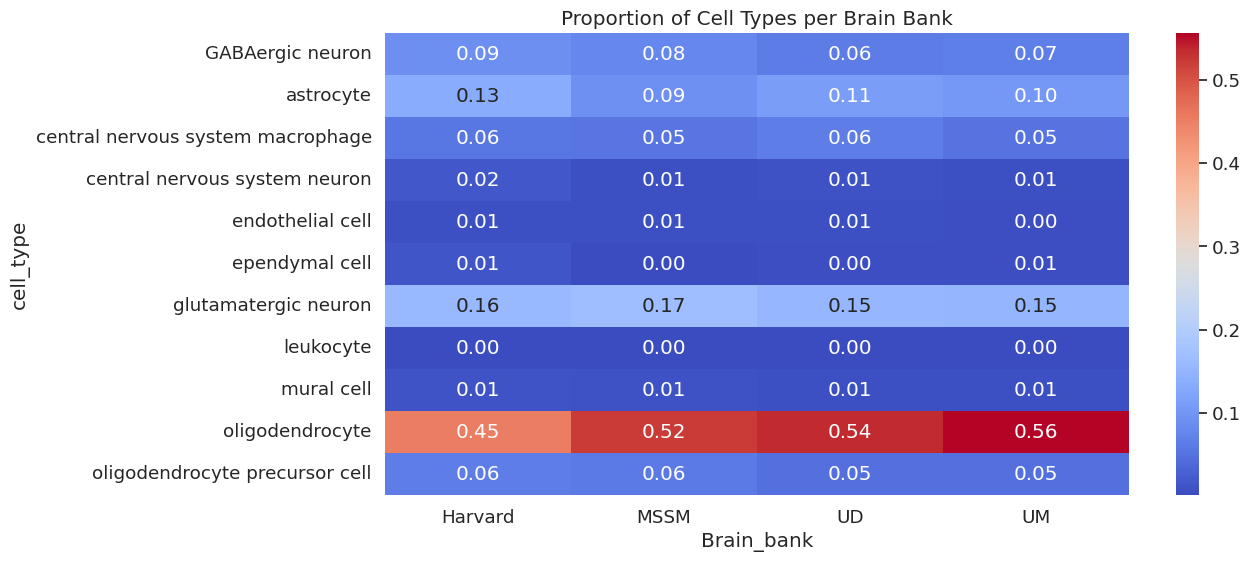

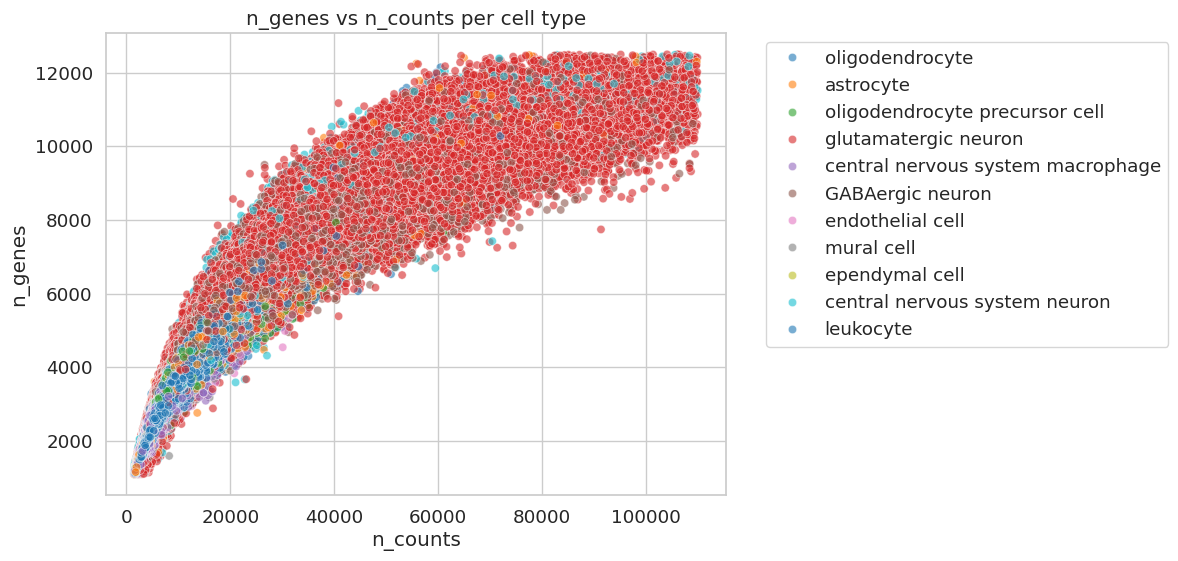

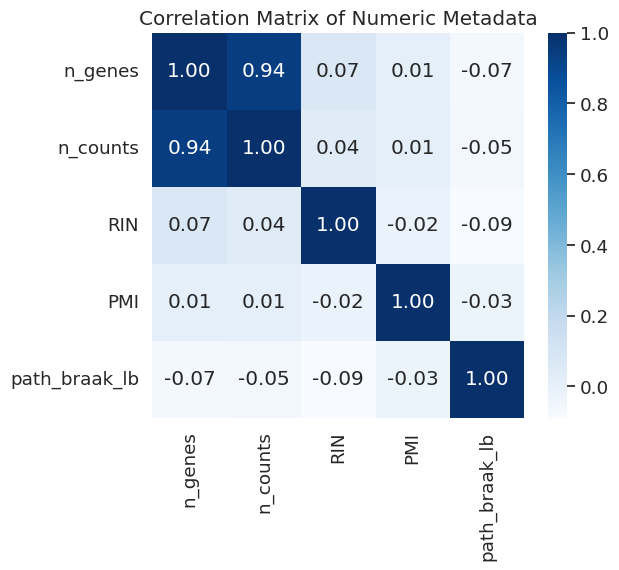

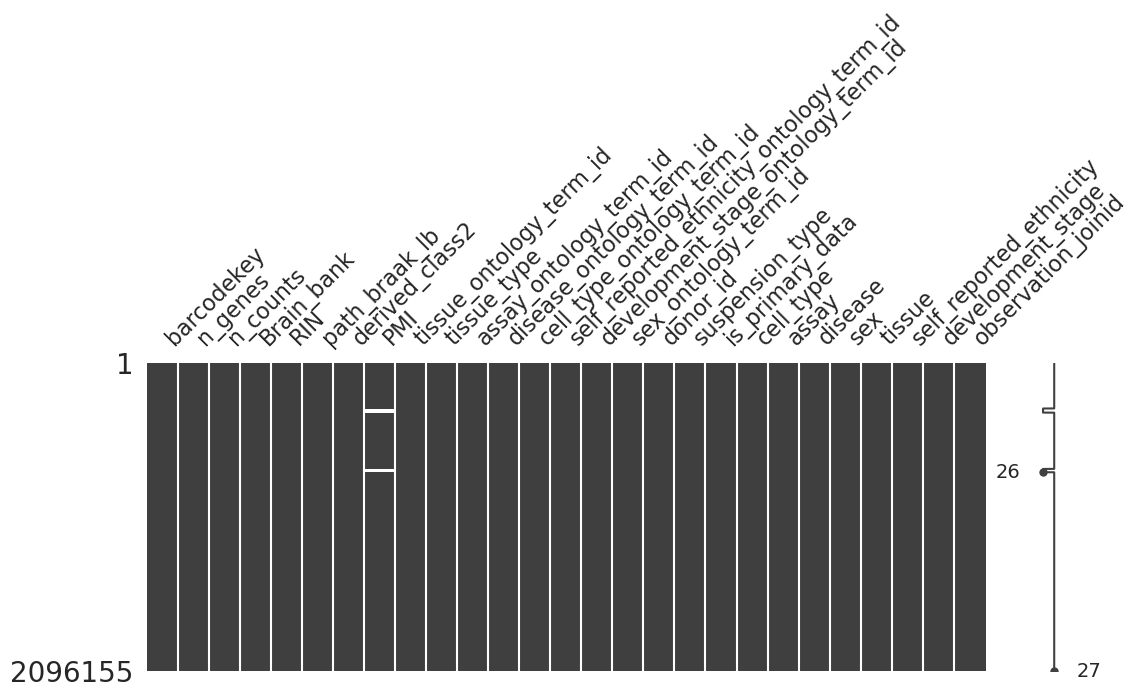

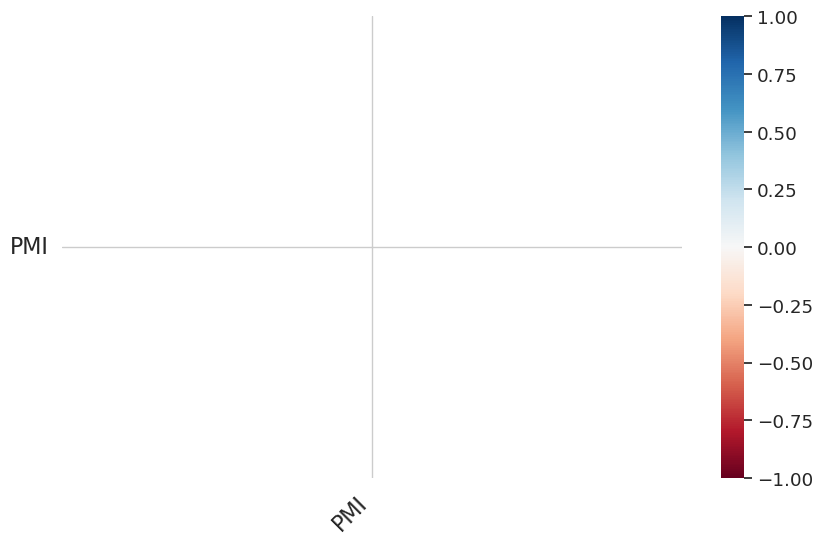

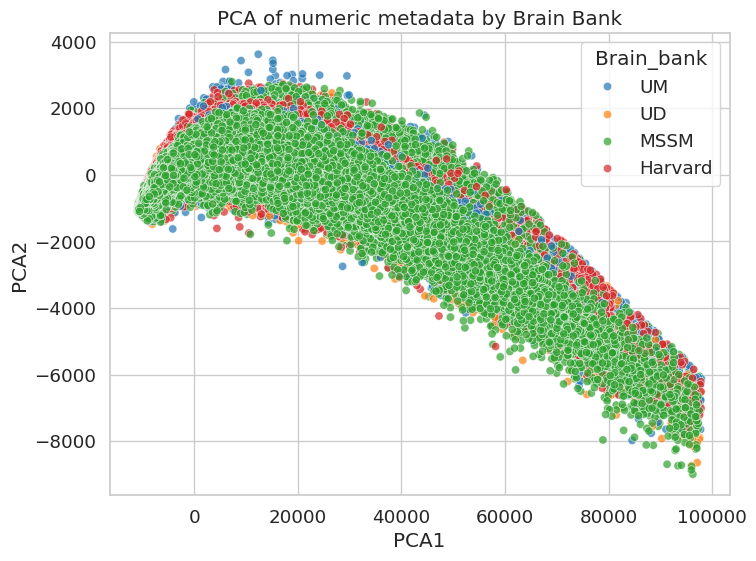

/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


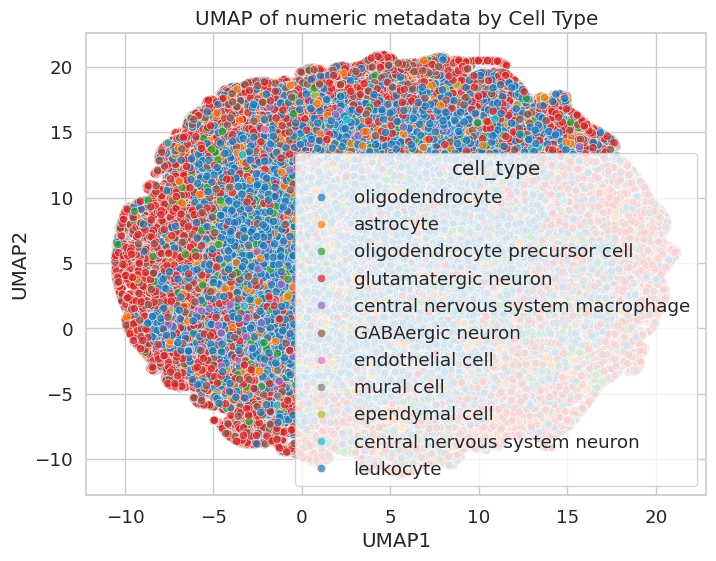

Number of cells flagged for QC: 1841025


/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


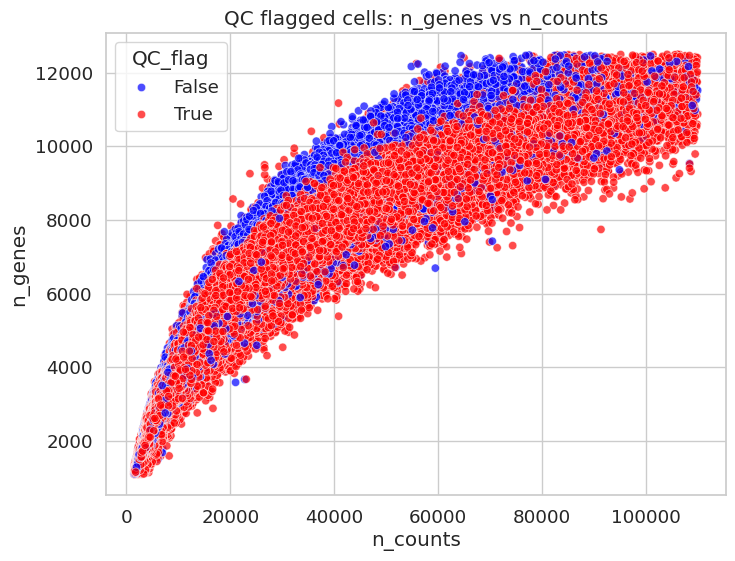

Enhanced metadata review complete.


In [11]:
# ================================================
# Enhanced Professional Review of scRNA-seq Metadata
# ================================================

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import missingno as msno

sns.set(style="whitegrid", palette="muted", font_scale=1.2)
%matplotlib inline

# -------------------------------
# 1. Load Metadata
# -------------------------------
metadata_path = '/projects/bioinformatics/DB/scRNAseq_parkinson/metadata.csv'
metadata = pd.read_csv(metadata_path)
print("Metadata dimensions:", metadata.shape)
metadata.head()

# -------------------------------
# 2. Basic Info
# -------------------------------
print(metadata.dtypes)
print(metadata.isna().sum())

# -------------------------------
# 3. Numeric Summary
# -------------------------------
numeric_cols = ['n_genes', 'n_counts', 'RIN', 'PMI', 'path_braak_lb']
metadata[numeric_cols].describe()

# Histograms & Boxplots
for col in numeric_cols:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(metadata[col], kde=True, ax=ax[0], color='skyblue')
    ax[0].set_title(f'Histogram of {col}')
    sns.boxplot(x=metadata[col], ax=ax[1], color='lightgreen')
    ax[1].set_title(f'Boxplot of {col}')
    plt.show()

# -------------------------------
# 4. Categorical Summary
# -------------------------------
categorical_cols = [
    'Brain_bank', 'derived_class2', 'tissue_ontology_term_id', 'tissue_type',
    'assay_ontology_term_id', 'disease_ontology_term_id', 
    'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
    'development_stage_ontology_term_id', 'sex_ontology_term_id',
    'suspension_type', 'is_primary_data', 'cell_type', 'assay',
    'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
]

for col in categorical_cols:
    counts = metadata[col].value_counts(dropna=False)
    plt.figure(figsize=(10,4))
    sns.barplot(x=counts.index, y=counts.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Cell count')
    plt.show()

# -------------------------------
# 5. Cross-tabulations
# -------------------------------
ct_bank = pd.crosstab(metadata['cell_type'], metadata['Brain_bank'])
ct_bank_norm = ct_bank.div(ct_bank.sum(axis=0), axis=1)
plt.figure(figsize=(12,6))
sns.heatmap(ct_bank_norm, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Proportion of Cell Types per Brain Bank')
plt.show()

# -------------------------------
# 6. Scatter: n_genes vs n_counts
# -------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(data=metadata, x='n_counts', y='n_genes', hue='cell_type', alpha=0.6, palette='tab10')
plt.title('n_genes vs n_counts per cell type')
plt.xlabel('n_counts')
plt.ylabel('n_genes')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

# -------------------------------
# 7. Correlations
# -------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(metadata[numeric_cols].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.title("Correlation Matrix of Numeric Metadata")
plt.show()

# -------------------------------
# 8. Missing Values
# -------------------------------
msno.matrix(metadata, figsize=(12,4))
plt.show()
msno.heatmap(metadata, figsize=(10,6))
plt.show()

# -------------------------------
# 9. PCA on numeric features
# -------------------------------
X = metadata[numeric_cols].fillna(metadata[numeric_cols].mean())
pca = PCA(n_components=2)
metadata[['PCA1', 'PCA2']] = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(data=metadata, x='PCA1', y='PCA2', hue='Brain_bank', alpha=0.7, palette='tab10')
plt.title('PCA of numeric metadata by Brain Bank')
plt.show()

# -------------------------------
# 10. UMAP on numeric features
# -------------------------------
reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
metadata[['UMAP1','UMAP2']] = reducer.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(data=metadata, x='UMAP1', y='UMAP2', hue='cell_type', alpha=0.7, palette='tab10')
plt.title('UMAP of numeric metadata by Cell Type')
plt.show()

# -------------------------------
# 11. QC Flags
# -------------------------------
# Define thresholds
low_genes = metadata['n_genes'] < 200
low_counts = metadata['n_counts'] < 500
low_RIN = metadata['RIN'] < 5
high_PMI = metadata['PMI'] > 24

metadata['QC_flag'] = low_genes | low_counts | low_RIN | high_PMI

print("Number of cells flagged for QC:", metadata['QC_flag'].sum())
metadata['QC_flag'].value_counts()

# Optional: visualize QC flagged cells
plt.figure(figsize=(8,6))
sns.scatterplot(data=metadata, x='n_counts', y='n_genes', hue='QC_flag', alpha=0.7, palette={True:'red', False:'blue'})
plt.title('QC flagged cells: n_genes vs n_counts')
plt.show()

# -------------------------------
# 12. Save metadata with QC
# -------------------------------
# metadata.to_csv('metadata_reviewed_QC.csv', index=False)

print("Enhanced metadata review complete.")


In [8]:
metadata["disease"]

0          Parkinson disease
1          Parkinson disease
2          Parkinson disease
3          Parkinson disease
4          Parkinson disease
                 ...        
2096150               normal
2096151    Parkinson disease
2096152    Parkinson disease
2096153               normal
2096154    Parkinson disease
Name: disease, Length: 2096155, dtype: object

In [6]:
metadata['observation_joinid']


0          MpT)aB)#*U
1          qFT~wG^BCg
2          fE`VpY%8fb
3          g1Lr8^y)O(
4          MR9tUCifao
              ...    
2096150    25FK4DT!Rl
2096151    PdMVWS9R^v
2096152    Q&?JBHEFAz
2096153    @vUY6<XF#a
2096154    *Ck9$@#b{s
Name: observation_joinid, Length: 2096155, dtype: object

In [8]:
obs_join_ids = list(metadata['observation_joinid'])
#obs_value_filter = 'observation_joinid in @obs_join_id'
obs_value_filter = f'observation_joinid in {obs_join_ids}'

In [101]:
obs_value_filter;

In [9]:
census = cellxgene_census.open_soma(census_version="2025-01-30")

# Meta Data 

In [10]:
cell_metadata = cellxgene_census.get_obs(
    census=census,
    organism="homo_sapiens",
    value_filter=obs_value_filter,
    column_names=["observation_joinid","cell_type"]
)

In [18]:
cell_metadata

observation_joinid                          cell_type
0               MpT)aB)#*U                    oligodendrocyte
1               qFT~wG^BCg                    oligodendrocyte
2               fE`VpY%8fb                    oligodendrocyte
3               g1Lr8^y)O(                    oligodendrocyte
4               MR9tUCifao                          astrocyte
...                    ...                                ...
2096150         25FK4DT!Rl                    oligodendrocyte
2096151         PdMVWS9R^v               glutamatergic neuron
2096152         Q&?JBHEFAz  central nervous system macrophage
2096153         @vUY6<XF#a     oligodendrocyte precursor cell
2096154         *Ck9$@#b{s                    oligodendrocyte

[2096155 rows x 2 columns]

# adata

In [19]:
# Some PBMC data from this data 
# 1. https://datasets.cellxgene.cziscience.com/88ad4023-93b2-4b70-a8a5-b0cf6c438cac.h5ad
#https://cellxgene.cziscience.com/collections/d5d0df8f-4eee-49d8-a221-a288f50a1590 <--- this we need to use

emb_names = ["scvi", "geneformer"]


census_version = "2025-01-30"


#dataset_ids = ["d5d0df8f-4eee-49d8-a221-a288f50a1590"]


with cellxgene_census.open_soma(census_version=census_version) as census:
    adata = cellxgene_census.get_anndata(
        census,
        organism="homo_sapiens",
        measurement_name="RNA",
        #obs_value_filter='dataset_id in ["d5d0df8f-4eee-49d8-a221-a288f50a1590"]',
        obs_embeddings=emb_names,
        obs_value_filter=obs_value_filter,
        obs_column_names = ["observation_joinid",'cell_type']
    )


In [18]:
adata.obs.columns

Index(['observation_joinid'], dtype='object')

In [11]:
adata.obsm

AxisArrays with keys: scvi, geneformer

In [12]:
df_scvi = pd.DataFrame(
    adata.obsm["scvi"], 
    index=adata.obs_names
)
df_scvi.to_csv("scvi_embedding.csv")

In [13]:
df_scvi

0         1         2         3         4             5   \
0       -0.004639  0.004547  0.215820  0.000767 -0.003586 -5.836487e-04   
1        0.000637  0.002472 -0.367188  0.001457 -0.003937 -2.151489e-03   
2       -0.002014  0.003387  0.188477 -0.001556 -0.001930 -1.823425e-03   
3       -0.001549  0.002762 -0.699219 -0.001869  0.000957 -1.289368e-03   
4        0.001930  0.000136 -0.925781 -0.006287  0.000839  3.738403e-03   
...           ...       ...       ...       ...       ...           ...   
2096150 -0.000866  0.003067  0.435547 -0.003006 -0.001381 -3.021240e-03   
2096151  0.006409  0.002167  0.058838  0.002426  0.000874 -5.699694e-07   
2096152  0.000675  0.001602  0.482422  0.001724 -0.005432 -3.738403e-03   
2096153  0.004181 -0.006500  0.195312  0.004181  0.002335  4.547119e-03   
2096154 -0.004242  0.005249  0.271484 -0.000355 -0.006866 -3.097534e-03   

               6         7         8         9   ...        40        41  \
0       -0.175781  0.333984 -0.001541 -0.003586  ...  0.001129 -0.351562   
1       -1.039062 -0.124023 -0.000167 -0.001587  ... -0.001511 -0.037109   
2       -0.644531 -0.241211 -0.000683  0.002594  ... -0.000984 -0.322266   
3       -0.484375 -0.076172  0.000041  0.001183  ... -0.003021  0.287109   
4        0.664062  0.914062 -0.001656  0.001312  ... -0.004089  0.398438   
...           ...       ...       ...       ...  ...       ...       ...   
2096150 -0.341797  0.159180 -0.000637 -0.000043  ... -0.001122 -0.058350   
2096151 -0.812500 -0.550781  0.004791  0.004364  ...  0.002930 -0.427734   
2096152 -0.765625  2.140625  0.000587 -0.011353  ... -0.002365  1.054688   
2096153  1.750000  0.136719 -0.003387 -0.000032  ... -0.000209 -0.115723   
2096154 -0.486328  1.546875  0.002029 -0.005005  ... -0.001244  0.185547   

               42        43        44        45        46        47        48  \
0       -0.003418 -0.000984  0.080566 -0.002121  0.464844  0.002518 -0.000188   
1        0.004395 -0.001526  0.031494  0.003479  0.921875  0.004028  0.005829   
2       -0.004150 -0.002365  0.157227  0.001373  0.597656  0.003510  0.001068   
3       -0.000553 -0.000504  0.186523  0.002701  0.753906  0.003204  0.000412   
4        0.005280  0.002396 -0.235352  0.003754  1.117188  0.000706  0.000736   
...           ...       ...       ...       ...       ...       ...       ...   
2096150 -0.001122 -0.002472 -0.144531 -0.002213  0.593750  0.001999 -0.001297   
2096151  0.000113  0.004211  0.562500  0.006561 -2.015625  0.000889  0.001968   
2096152 -0.000340 -0.003113  0.235352 -0.008301  0.644531 -0.001823  0.001587   
2096153  0.004028  0.001289  1.007812 -0.007019 -0.022339 -0.001122 -0.003845   
2096154 -0.004364 -0.002960  0.084473 -0.002884  0.617188  0.003418  0.004059   

               49  
0       -0.004028  
1        0.001801  
2        0.001114  
3       -0.003784  
4       -0.002579  
...           ...  
2096150 -0.002502  
2096151  0.005219  
2096152 -0.004272  
2096153 -0.002792  
2096154 -0.001648  

[2096155 rows x 50 columns]

In [87]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: scvi, geneformer)


In [88]:
print(adata.shape)  
print(adata.obs.head())

(0, 61888)
Empty DataFrame
Columns: [observation_joinid, dataset_id]
Index: []


In [18]:
df_scvi.shape

(2096155, 50)

In [14]:
df_geneformer = pd.DataFrame(
    adata.obsm["geneformer"], 
    index=adata.obs_names
)
df_geneformer.to_csv("geneformer_embedding.csv")


In [15]:
df_geneformer.head()

0         1         2         3         4         5         6    \
0  0.121582 -0.871094 -0.396484  0.726562 -0.746094  0.267578  0.170898   
1  0.550781 -1.140625  0.012146  0.437500 -0.968750 -0.048584  0.150391   
2 -0.093750 -1.851562  0.316406 -0.691406 -0.871094 -0.035156  0.202148   
3  0.039062 -2.015625  0.009949  0.519531 -1.148438 -0.000176  0.625000   
4  0.527344 -1.343750  0.554688  1.023438 -0.221680 -0.519531  0.104492   

        7         8         9    ...       502       503       504       505  \
0  1.382812  0.964844  0.511719  ... -0.808594 -1.250000  0.593750 -0.490234   
1  0.687500  0.291016  1.109375  ... -0.271484 -0.570312  0.091309 -0.470703   
2 -0.015076  0.410156  0.515625  ...  0.792969 -0.710938  0.337891  0.593750   
3  0.291016  0.636719  1.054688  ... -0.119141 -0.570312 -0.084473  0.287109   
4  0.738281 -0.328125  0.527344  ... -0.134766 -0.400391  0.056641 -0.667969   

        506       507       508       509       510       511  
0  0.257812  0.968750 -0.843750 -0.226562  0.099609 -0.328125  
1 -0.159180  1.109375 -0.406250  0.184570 -0.257812 -0.369141  
2  0.032227  0.141602  0.343750  0.867188 -0.671875 -0.625000  
3  0.138672  0.447266 -0.105469  1.164062 -0.337891 -0.875000  
4  0.482422  1.132812 -0.734375 -0.269531  0.310547 -0.417969  

[5 rows x 512 columns]

In [17]:
df_geneformer.shape

(2096155, 512)

# scVI  embedding UMAP

In [15]:
df_scvi = pd.read_csv("/projects/bioinformatics/DB/scRNAseq_parkinson/scvi_embedding.csv", index_col=0)

In [20]:
# For scVI embedding
reducer = umap.UMAP()
embedding_scvi_umap = reducer.fit_transform(df_scvi.values)

/var/tmp/pbs.402076.pbs01/ipykernel_240407/1319384069.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  codes = cell_types.cat.codes[df_scvi.index]


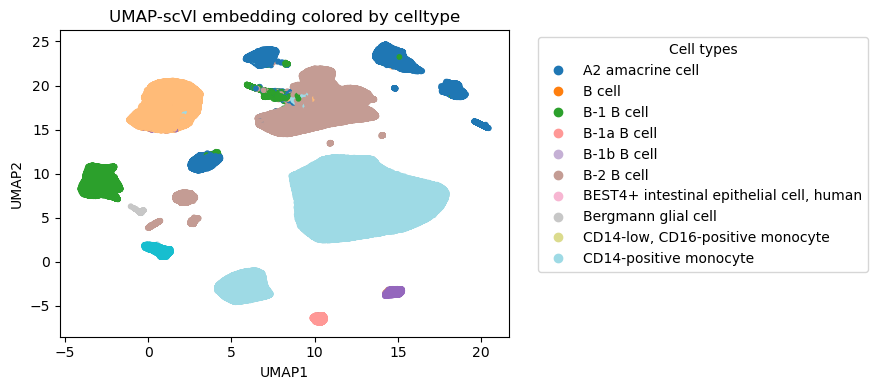

In [22]:

cell_types = adata.obs["cell_type"].astype("category")
codes = cell_types.cat.codes[df_scvi.index]

plt.figure(figsize=(9,4))
scatter = plt.scatter(
    embedding_scvi_umap[:,0],
    embedding_scvi_umap[:,1],
    c=codes,
    cmap="tab20",
    s=10
)


handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, cell_types.cat.categories, title="Cell types", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("scVI embedding")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


# Geneformer embedding UMAP

In [23]:
df_geneformer = pd.read_csv("/projects/bioinformatics/DB/scRNAseq_parkinson/geneformer_embedding.csv", index_col=0)

In [24]:
# For geneformer embedding
reducer = umap.UMAP()
embedding_geneformer_umap = reducer.fit_transform(df_geneformer.values)

/var/tmp/pbs.402076.pbs01/ipykernel_240407/840806851.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  codes = cell_types.cat.codes[df_geneformer.index]


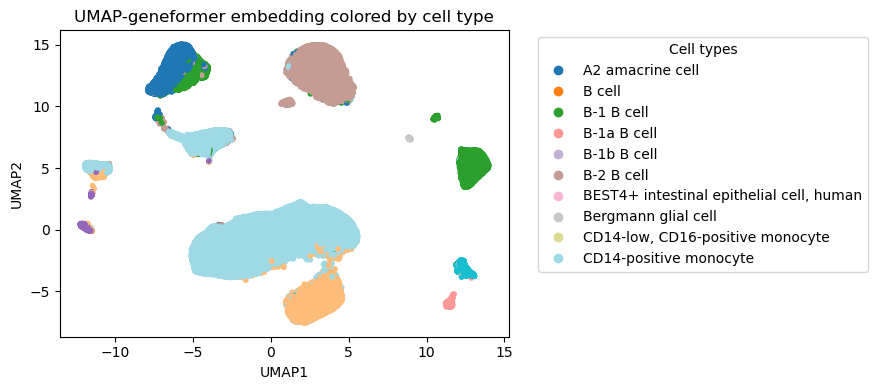

In [25]:
cell_types = adata.obs["cell_type"].astype("category")
codes = cell_types.cat.codes[df_geneformer.index]

plt.figure(figsize=(9,4))
scatter = plt.scatter(
    embedding_geneformer_umap[:,0],
    embedding_geneformer_umap[:,1],
    c=codes,
    cmap="tab20",
    s=10
)

handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, cell_types.cat.categories, title="Cell types", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("UMAP-geneformer embedding colored by cell type")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.tight_layout()
plt.show()


# Leiden Clustering

In [ ]:
# convert to AnnData
adata = ad.AnnData(df_scvi.values)
adata.obs_names = df_scvi.index
adata.var_names = df_scvi.columns

# build graph
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')

# Leiden clustering
sc.tl.leiden(adata, resolution=0.6)

# save clusters
adata.obs[['leiden']].to_csv("scvi_leiden_clusters.csv")


/home/znazari/cellxgene_census2025_new/lib/python3.12/site-packages/anndata/_core/anndata.py:812: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/var/tmp/pbs.402076.pbs01/ipykernel_240407/236350035.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.6)


To know whether your **adata** object is already *log-transformed* or *already normalized*, you need to check **two things**:

---

# ✅ **1. Check `.raw`**

Many datasets come with precomputed log-normalized expression stored in:

```python
adata.raw
```

If this exists and is not `None`, the data is *usually* already log-normalized (e.g., Seurat exports).

Check:

```python
print(adata.raw is not None)
print(adata.raw)
```

* If `adata.raw` exists → it likely contains **log-normalized data**.
* If it does not exist → your matrix is probably raw counts or unprocessed.

---

# ✅ **2. Check the ranges of values in `adata.X`**

### ✔ Raw counts example:

Raw counts are integers and typically look like:

```
0, 1, 0, 3, 10, 0, 2, 0, 50, 120, ...
```

Check with:

```python
adata.X[:5, :5]
adata.X.max(), adata.X.min()
```

Indicators of raw counts:

* Values are integers
* Range is large (0 to thousands)
* Heavy zeros

---

### ✔ Log1p-transformed example:

After log1p (log(x+1)), values look like:

```
0.0, 0.69, 1.39, 2.30, 3.75, ...
```

Check:

```python
import numpy as np
np.mean(adata.X), np.max(adata.X)
```

Indicators of log-transformed data:

* Values are **floats**, not integers
* Typically between **0 and 5–12**
* No extremely large values

---

### ✔ Library-size normalized (but NOT log-transformed):

After `sc.pp.normalize_total`, before log1p:

Values look like:

```
0.0, 0.01, 0.002, 0.05, ...
```

Range:

* Typically **0 to maybe 50**
* Always **floats**
* No integers
* But distribution is very skewed

---

# ✅ **3. Check `adata.uns['log1p']`**

Scanpy automatically stores metadata if log1p was applied:

```python
adata.uns.get('log1p')
```

If this prints something like:

```
{'base': None}
```

→ log1p has already been applied.

If it returns `None` → log1p was probably NOT applied.

---

# 🔍 Summary Table

| Expression Matrix   | How to Detect                                        | Meaning                                                    |
| ------------------- | ---------------------------------------------------- | ---------------------------------------------------------- |
| **Raw counts**      | integer values, `.raw` is None                       | Apply HVG (Seurat-style), then normalize + log             |
| **Normalized only** | float values, not log1p, `.uns['log1p']` missing     | You must apply log1p                                       |
| **Log-normalized**  | values 0–5/10, `.uns['log1p']` exists, `.raw` exists | Skip normalization/log, HVG from raw is no longer possible |

---

# ✔ If you want, I can check your `adata` for you

Just run:

```python
adata.X[:10, :10]
adata.X.max(), adata.X.min()
adata.raw
adata.uns.get('log1p')
```

Paste the output here, and I will tell you **exactly** what stage your data is in.
